# Panorama geral dos Servidores Públicos do Poder Executivo 

- Os dados são obtidos do Portal da Transparência do Poder Executivo Federal (https://www.portaldatransparencia.gov.br/download-de-dados/servidores) 

- Os arquivos possuem informações mensais. O Objetivo é transformar os arquivos em uma leitura quantitativa de fácil entendimento com novas tabelas e alguns gráficos (com os indicadores de maior destaque)

- Com o intuito de verificar a evolução do panorama geral, os arquivos mensais dos meses de dezembro (aaaa12) e 202205 (mais recente) são acumulados em pasta própria para criação de gráficos históricos. A depender da data de execução, pode-se haver arquivo mais recente. Para verificar, acessar o link disponibilizado acima. 

- Por fim, para verificar a evolução hitórica de cada um dos cargos (pouco mais de 2000 cargos),considerando a evolução anual mencionada acima, é feita uma comparação entre a inflação do período, a remuneração e o quantitativo de cada cargo. Para todos efeitos, são consideradas as remunerações básicas brutas no período, que é a informação disponibilizada no portal. 

- Abaixo, seguem, com mais detalhes as informações obtidas e os passos seguidos: 

### Escolha do ano mes referência

- Tendo em vista que os arquivos são obtidos considerando o ano mês de referência, possibilitou-se que o usuário informe e escolha o ano e mês desejado. 

- Lembrando que, se for escolhido algum mês de dezembro, o arquivo será salvo para utilização nos relatórios anuais (ex.: 201412, 201512, 201612). Obs.: o arquivo mais antigo disponível é referente a 201401.

- Além disso, os arquivos referente aos servidores militares são disponibilizados em arquivos separados. Por esta razão, deu-se a opção para que o usuário escolha ou não essa opção. A escolha refetirá nos resultados que serão apresentados. 

In [1423]:
referencia = input("Digite o ano e mês de referência (aaaamm): ")
milico = input("Deseja incluir informações sobre os militares? (s / n): ").upper()

Digite o ano e mês de referência (aaaamm): 201812
Deseja incluir informações sobre os militares? (s / n): s


### Importação Bibliotecas Básicas

In [1424]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import zipfile
from io import BytesIO
import requests
import seaborn as sns
import time
import shutil                       # para exclusão de diretórios com arquivos dentro
import warnings                     # bibliteca para retirar os alertas 
warnings.filterwarnings('ignore')   #  chamando a bibliteca para retirar os alertas
from tqdm import tqdm               # para mostrar a progressão com a barra de carregamento

In [1425]:
# tempo para "rodar" o código

tempo_inicial = time.time()

### Criação de Pastas para Salvar os Respectivos arquivos Mensais, bem como os Resultados

- Com a finalidade de organizar as extrações e os resultados obtdos, bem como possibilitar o acúmulo para os relatórios anuais, algumas pastas serão criadas ao executar o código (esta ação somente será executada se a execução acontecer no ambiente windows. 

In [1426]:
os.makedirs("PORTAL DA TRANSPARENCIA",exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} EXTRAÇÕES".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} EXTRAÇÕES/Servidores_SIAPE".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} EXTRAÇÕES/Servidores_BACEN".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} EXTRAÇÕES/Militares".format(referencia),exist_ok=True)

# Criação de pasta para salvar os respectivos documentos de cada mês

os.makedirs("PORTAL DA TRANSPARENCIA/{} RESULTADOS".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} RESULTADOS/Graficos em PDF".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} RESULTADOS/Graficos em JPG".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/{} RESULTADOS/Tabelas".format(referencia),exist_ok=True)

# Criação de pasta para incluir somente os arquivos para utilização de gráficos anuais

os.makedirs("PORTAL DA TRANSPARENCIA/Temp".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Civil x Militar".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Pessoal por Órgao - Lotação".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Pessoal por Órgao - Exercício".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Quantitativo por Vínculo Funcional".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Quantitativo por Regime Jurídico".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Regime Jurídico Por Orgao (Lotação)".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Regime Jurídico Por Orgao (Exercício)".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Vinculo Funcional Por Orgao (Lotação)".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Vinculo Funcional Por Orgao (Exercicio)".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/Temp/Quantitativo Por Cargo e Remuneração".format(referencia),exist_ok=True)


# Criação de pasta para Gráficos Históricos 
os.makedirs("PORTAL DA TRANSPARENCIA/GRÁFICOS HISTÓRICOS".format(referencia),exist_ok=True)
os.makedirs("PORTAL DA TRANSPARENCIA/GRÁFICOS HISTÓRICOS\Remuneração Cargos".format(referencia),exist_ok=True)


### Importação do Banco de Dados do Mês e salvando em suas respectivas pastas

- O bando de dados mensal é dispoibilizado no seguinte endereço: https://www.portaldatransparencia.gov.br/download-de-dados/servidores/{}_Servidores_SIAPE. 
- As chaves são a referencia inicial informada pelo usuário. Assim, o arquivo que é importado é aquele do respetivo ano mês escolhidos pelo usuário. 
- Os arquivos vem no formato .zip e, por esta razão, é preciso utilizar a biblioteca zipfile
- Se o usuário ópita por incluir os militares, serão realizadas 03 dowloads, caso contrário, serão feitos 02 (servidores e servidores do Banco Central) 
- Cada arquivo "zipado" possui 4 arquivos csv. Serão utilizados dois arquivos (Cadastro e Remuneração) 

In [1427]:
# Servidores

url_servidores = "https://www.portaldatransparencia.gov.br/download-de-dados/servidores/{}_Servidores_SIAPE".format(referencia)

servidores = BytesIO(requests.get(url_servidores).content)

myzip = zipfile.ZipFile(servidores)
myzip.extractall("PORTAL DA TRANSPARENCIA/{} Extrações/Servidores_SIAPE".format(referencia))

In [1428]:
# Servidores do BACEN

url_servidores_bacen = "https://www.portaldatransparencia.gov.br/download-de-dados/servidores/{}_Servidores_BACEN".format(referencia)

servidores_bacen = BytesIO(requests.get(url_servidores_bacen).content)

myzip = zipfile.ZipFile(servidores_bacen)
myzip.extractall("PORTAL DA TRANSPARENCIA/{} Extrações/Servidores_BACEN".format(referencia))

In [1429]:
# Militares

if milico == "S":

    url_militares = "https://www.portaldatransparencia.gov.br/download-de-dados/servidores/{}_Militares".format(referencia)

    militares = BytesIO(requests.get(url_militares).content)

    myzip = zipfile.ZipFile(militares)
    myzip.extractall("PORTAL DA TRANSPARENCIA/{} Extrações/Militares".format(referencia))

else:
    pass

### Realizando a Leitura dos arquivos (Cadastro)

- Atribuição de variáveis os respectivos arquivos de dados do cadastro

In [1430]:
# Servidores

servidores = pd.read_csv(r'PORTAL DA TRANSPARENCIA/{} Extrações/Servidores_SIAPE/{}_Cadastro.csv'.format(referencia, referencia), encoding = "ISO-8859-1", sep=';', low_memory=False)

In [1431]:
# Servidores do BACEN

servidores_bacen = pd.read_csv(r'PORTAL DA TRANSPARENCIA/{} Extrações/Servidores_BACEN/{}_Cadastro.csv'.format(referencia, referencia), encoding = "ISO-8859-1", sep=';',)

In [1432]:
# Militares

if milico == "S":
    
    militares = pd.read_csv(r'PORTAL DA TRANSPARENCIA/{} Extrações/Militares/{}_Cadastro.csv'.format(referencia, referencia), encoding = "ISO-8859-1", sep=';', low_memory=False)
else: 
    pass


### União de todos os arquivos (Cadastro)

- União de todos os arquivos do cadastro com o concat: Servidores + Servidores_Bacen + Militares (se for o caso)

In [1433]:
base = servidores

In [1434]:
base = pd.concat([servidores, servidores_bacen])



In [1435]:
if milico == "S":
    base = pd.concat([base, militares])
else:
    pass

### Realizando a Leitura dos arquivos (Remuneração) 

- Atribuição de variáveis os respectivos arquivos de dados da remuneração

In [1436]:
remun_servidores = pd.read_csv(r'PORTAL DA TRANSPARENCIA/{} Extrações/Servidores_SIAPE/{}_Remuneracao.csv'.format(referencia, referencia), encoding = "ISO-8859-1", sep=';', low_memory=False)

In [1437]:
remun_servidores_bacen = pd.read_csv(r'PORTAL DA TRANSPARENCIA/{} Extrações/Servidores_BACEN/{}_Remuneracao.csv'.format(referencia, referencia), encoding = "ISO-8859-1", sep=';', low_memory=False)

In [1438]:
if milico == "S":
    
    remun_militares = pd.read_csv(r'PORTAL DA TRANSPARENCIA/{} Extrações/Militares/{}_Remuneracao.csv'.format(referencia, referencia), encoding = "ISO-8859-1", sep=';', low_memory=False)
else:
    pass

### União de todos os arquivos (Remuneração)

- União de todos os arquivos da remuneração com o concat: Servidores + Servidores_Bacen + Militares (se for o caso)

In [1439]:
remun = pd.concat([remun_servidores, remun_servidores_bacen])

In [1440]:
if milico == "S":
    remun = pd.concat([remun,remun_militares])
else:
    pass

### Exclusão de Colunas desnecessárias e Tratamento de Dados 

- A fim de diminuir a quantidade de dados para agilizar o processamento, realizou-se a exclusão de colunas consideradas desnecessárias para o estudo
- Tratamento de alguns dados 

In [1441]:
# visualizando as colunas (Base) para facilitar a exclusao das não desejadas

#print(list(base.columns))

In [1442]:
base = base.drop(['MATRICULA','CLASSE_CARGO', 'REFERENCIA_CARGO', 'PADRAO_CARGO', 'NIVEL_CARGO', 'CODIGO_ATIVIDADE', 'ATIVIDADE', 'OPCAO_PARCIAL', 'DATA_INICIO_AFASTAMENTO', 'DATA_TERMINO_AFASTAMENTO', 'DATA_NOMEACAO_CARGOFUNCAO', 'DOCUMENTO_INGRESSO_SERVICOPUBLICO', 'DATA_DIPLOMA_INGRESSO_SERVICOPUBLICO', 'DIPLOMA_INGRESSO_CARGOFUNCAO', 'DIPLOMA_INGRESSO_ORGAO', 'DIPLOMA_INGRESSO_SERVICOPUBLICO'], axis=1)

In [1443]:
# visualizando as colunas (Remun) para facilitar a exclusao das não desejadas

#print(list(remun.columns))

In [1444]:
# exclusão de colunas desnecessárias ao estudo

remun = remun.drop(['ANO', 'MES', 'CPF', 'NOME','REMUNERAÇÃO BÁSICA BRUTA (U$)', 'ABATE-TETO (R$)', 'ABATE-TETO (U$)', 'GRATIFICAÇÃO NATALINA (R$)', 'GRATIFICAÇÃO NATALINA (U$)', 'ABATE-TETO DA GRATIFICAÇÃO NATALINA (R$)', 'ABATE-TETO DA GRATIFICAÇÃO NATALINA (U$)', 'FÉRIAS (R$)', 'FÉRIAS (U$)','OUTRAS REMUNERAÇÕES EVENTUAIS (U$)', 'IRRF (R$)', 'IRRF (U$)', 'PSS/RPGS (R$)', 'PSS/RPGS (U$)', 'DEMAIS DEDUÇÕES (R$)', 'DEMAIS DEDUÇÕES (U$)', 'PENSÃO MILITAR (R$)', 'PENSÃO MILITAR (U$)', 'FUNDO DE SAÚDE (R$)', 'FUNDO DE SAÚDE (U$)', 'TAXA DE OCUPAÇÃO IMÓVEL FUNCIONAL (R$)', 'TAXA DE OCUPAÇÃO IMÓVEL FUNCIONAL (U$)','REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (U$)', 'VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - CIVIL (R$)(*)', 'VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - CIVIL (U$)(*)', 'VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - MILITAR (R$)(*)', 'VERBAS INDENIZATÓRIAS REGISTRADAS EM SISTEMAS DE PESSOAL - MILITAR (U$)(*)', 'VERBAS INDENIZATÓRIAS PROGRAMA DESLIGAMENTO VOLUNTÁRIO \x96 MP 792/2017 (R$)', 'VERBAS INDENIZATÓRIAS PROGRAMA DESLIGAMENTO VOLUNTÁRIO \x96 MP 792/2017 (U$)', 'TOTAL DE VERBAS INDENIZATÓRIAS (U$)(*)'], axis=1)

In [1445]:
# substituindo "," por "."

remun["REMUNERAÇÃO BÁSICA BRUTA (R$)"] = remun["REMUNERAÇÃO BÁSICA BRUTA (R$)"].str.replace(",", ".") 
remun["REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R$)"] = remun["REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R$)"].str.replace(",", ".") 
remun["TOTAL DE VERBAS INDENIZATÓRIAS (R$)(*)"] = remun["TOTAL DE VERBAS INDENIZATÓRIAS (R$)(*)"].str.replace(",", ".") 

In [1446]:
# conversão de Types
remun["REMUNERAÇÃO BÁSICA BRUTA (R$)"] = remun["REMUNERAÇÃO BÁSICA BRUTA (R$)"].astype("float64")
remun["REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R$)"] = remun["REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R$)"].astype("float64")
remun["TOTAL DE VERBAS INDENIZATÓRIAS (R$)(*)"] = remun["TOTAL DE VERBAS INDENIZATÓRIAS (R$)(*)"].astype("float64")

In [1447]:
# acréscimo de coluna com o valor Recebido pelo servidor 

remun["REMUNERAÇÃO LIQUIDA(*)"] = remun["REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R$)"] + remun["TOTAL DE VERBAS INDENIZATÓRIAS (R$)(*)"]

### União das bases Cadastro + Remuneração e Tratamento de dados

- Para transformar todos os dados até então obtidos em uma única variável, utilizou-se do "merge" tendo como referência o "Id_SERVIDOR_PORTAL", que é a única informação existentes nas duas bases de dados.  
- Após a união do dados, realizou-se mais alguns tratamentos no dados 

In [1448]:
# união dos dois DFs, considerando a base como referência 

base = pd.merge(base, remun, on = "Id_SERVIDOR_PORTAL", how="left")

In [1449]:
# criação de nova colunar para facilitar a contagem

base["CONT"] = 1

In [1450]:
# Ajustando a coluna "ORGSUP_LOTACAO" para que não fiquem linhas sem informações 

base.loc[base["COD_ORGSUP_LOTACAO"] == -1, "ORGSUP_LOTACAO"] = base["ORG_LOTACAO"]


In [1451]:
# Padronização de todos os Strings para que fiquem com a Primeira Letra de cada palavra em maiúsculo (.str.title())

base["ORG_EXERCICIO"] = base["ORG_EXERCICIO"].str.title()
base["ORG_LOTACAO"] = base["ORG_LOTACAO"].str.title()
base["SITUACAO_VINCULO"] = base["SITUACAO_VINCULO"].str.title()
base["REGIME_JURIDICO"] = base["REGIME_JURIDICO"].str.title()
base["ORG_LOTACAO"] = base["ORG_LOTACAO"].str.title()
base["DESCRICAO_CARGO"] = base["DESCRICAO_CARGO"].str.title()
base["NOME"] = base["NOME"].str.title()

## Agrupamentos para elaboração de gráficos e Verificação dos indicadores

- Para elaboração dos gráficos e tabelas alguns agrupamentos foram relizados e serão abordados a medida de suas ocorrências 

### CIVIL x MILITAR

- Para verificar e comparar a quantidade de servidores civis e militares.
- Criação de variável somente com as informações desejadas da base 
- O agrupamento foi realizado em Civil x Militar e a soma realizada. Após esta etapa, foram inseridas colunas com a respectiva quantidade da categoria 
- Considerando que o banco de dados traz alguns valores (Id_SERVIDOR_PORTAL) repetidos optou-se por retirá-los. 
- As repetições acontecem, pois, em alguas situações o servidor possui mais de um vínculo funcional se, por exemplo, for servidor e também possuir alguma função, servidor cedido a outro órgão que não o seu origiário. Por esta razão, para que não haja prejuízo nos dados, optou-se por retirá-los. 
- Apesar de estar em desuso, optou-se por apresentar um gráfico de pizza, pois são somente duas informações


In [1452]:
civ_milico = base[["Id_SERVIDOR_PORTAL","SITUACAO_VINCULO","CONT"]]


In [1453]:
civ_milico.loc[civ_milico["SITUACAO_VINCULO"] == "Militar Da Ativa", "CIVIL x MILITAR"] = "Militar"
civ_milico.loc[civ_milico["CIVIL x MILITAR"] != "Militar", "CIVIL x MILITAR"] = "Civil"



In [1454]:
civ_milico["REFERENCIA"] = referencia

In [1455]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez

civ_milico = civ_milico.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por CIVIL x MILITAR e resetando o index para facilitar o manuseio 

civ_milico = civ_milico.groupby("CIVIL x MILITAR")["CONT"].sum()
civ_milico = civ_milico.reset_index()
civ_milico = civ_milico.sort_values(by = "CONT", ascending=False)
civ_milico = civ_milico.reset_index()

civ_milico["PORCENTAGEM"] = civ_milico["CONT"]/civ_milico["CONT"].sum()
civ_milico = civ_milico.drop("index", axis=1)
civ_milico["REFERENCIA"] = referencia

civ_milico.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\AA - Civil x Militar {}.xlsx".format(referencia, referencia), index= False)
if referencia[4:] == "12":
    civ_milico.to_excel("PORTAL DA TRANSPARENCIA/Temp/Civil x Militar\AA - Civil x Militar {}.xlsx".format(referencia, referencia), index= False)
elif referencia == "202205":
    civ_milico.to_excel("PORTAL DA TRANSPARENCIA/Temp/Civil x Militar\AA - Civil x Militar {}.xlsx".format(referencia, referencia), index= False)

else:
    pass

In [1456]:
# Gráfico de Pizza para Militar x Civil

if milico == "S":
    
    fig, ax = plt.subplots(dpi=100,figsize=(10,10))

    labels = civ_milico["CIVIL x MILITAR"]
    sizes = civ_milico["PORCENTAGEM"]
    explode = (0, 0.1)  # apenas "explode" a 2ª fatia (ou seja, 'Porcos')


    ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.axis('equal')  # Proporção igual garante que a pizza seja desenhada como um círculo.


    plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\AA- Civil x Militar {}.jpg".format(referencia, referencia),transparent = True)
    plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\AA- Civil x Militar {}.pdf".format(referencia, referencia),transparent = True)
    plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória

else: 
    pass

### ORGAO LOTACAO

- Tem a finalidade de verificar quantos servidores existem em cada órgão, considerando a LOTAÇÃO
- A metodologia aplicada foi e mesma que aquela aplicada ao CIVIL x MILITAR
- Foi criado um gráfico de barras horizontais que contém órgãos com mais de 1500 servidores LOTADOS

In [1457]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez

org_lotacao = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

org_lotacao = org_lotacao.groupby("ORG_LOTACAO")["CONT"].sum()
org_lotacao = org_lotacao.reset_index()
org_lotacao = org_lotacao.sort_values(by = "CONT", ascending=False)
org_lotacao = org_lotacao.reset_index()

org_lotacao["PORCENTAGEM"] = org_lotacao["CONT"]/org_lotacao["CONT"].sum()

In [1458]:
# para facilitar a visualização do gráfico, filtrou-se somente órgãos que possuem mais do que 1500 pessoas
# a listagem completa sem cortes, está na variável org_lotacao_list
org_lotacao_list = org_lotacao
org_lotacao_list = org_lotacao_list.drop("index", axis=1)
org_lotacao_list["REFERENCIA"] = referencia
org_lotacao_list.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\A-Total Pessoal por Órgao (Lotação) {}.xlsx".format(referencia, referencia), index= False)
if referencia[4:] == "12":
    org_lotacao_list.to_excel("PORTAL DA TRANSPARENCIA\Temp\Pessoal por Órgao - Lotação\A-Total Pessoal por Órgao (Lotação) {}.xlsx".format(referencia, referencia), index= False)
elif referencia == "202205":
     org_lotacao_list.to_excel("PORTAL DA TRANSPARENCIA\Temp\Pessoal por Órgao - Lotação\A-Total Pessoal por Órgao (Lotação) {}.xlsx".format(referencia, referencia), index= False)
else:
    pass
        
org_lotacao = org_lotacao.loc[org_lotacao["CONT"] > 1500, :]


In [1459]:
# Elaboração de gráfico de barras horizontais com o quantitativo de pessoal por órgão 

fig, ax = plt.subplots(dpi=200, figsize=(20,30))

ax.set_title("Total Pessoal por Órgao (Lotação){}".format(referencia), # Título do gráfico
             fontsize=20,                                            # Tamanho da fonte (título)
             fontweight='bold',                                      # Espessura da fonte (título)
             color='#000000'                                         # Cor da fonte (título)
            )
ax.barh(org_lotacao["ORG_LOTACAO"],org_lotacao['CONT'],
        color = "#00FF00",                                             # Cor das barras
        edgecolor='black',                                           # Contorno barras
        align='center',                                              # Alinhamento
       )

for i in np.arange(0, len(list(org_lotacao["ORG_LOTACAO"]))):
    ax.annotate(org_lotacao['CONT'][i],                                       # texto do annotate
                  (org_lotacao['CONT'][i], i),                                # posição x, y
                    ha="center",                                      # ajutes de posição
                    va = "top",
                    xytext=(25,5), 
                    textcoords = "offset points", 
                    fontsize=12,                                      # Tamanho da fonte (anotação)
                    color = '#000000',                                # Cor da fonte (anotação)
                    )

for i in np.arange(0, len(list(org_lotacao["ORG_LOTACAO"]))):
    if org_lotacao["PORCENTAGEM"][i] > 1:
        ax.annotate("{:,.0f}%".format(org_lotacao["PORCENTAGEM"][i]*100), # texto do annotate
                      (org_lotacao["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(70,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#006400',
                        fontweight='bold')
    elif (org_lotacao["PORCENTAGEM"][i] < 1) & (org_lotacao["PORCENTAGEM"][i] > 0.009):
        ax.annotate("{:,.2f}%".format(org_lotacao["PORCENTAGEM"][i]*100), # texto do annotate
                      (org_lotacao["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(70,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#006400',
                        fontweight='bold')   
    else:
        ax.annotate("{:,.4f}%".format(org_lotacao["PORCENTAGEM"][i]*100), # texto do annotate
                      (org_lotacao["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(70,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#006400',
                        fontweight='bold')    
    
    
ax.invert_yaxis()                                                     # inverte para ficar do maior para o menor
ax.xaxis.set_visible(False)                                           # retira os valores de x
ax.tick_params(axis='y',labelsize=12, color="w")                                 # ajusta o tamanho dos valores de Y
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.tight_layout()                                                   # para enquadrar melhor a imagem e não cortar nenhum pedaço
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\A-Total Pessoal por Órgao (Lotação) {}.jpg".format(referencia, referencia),transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\A-Total Pessoal por Órgao (Lotação) {}.pdf".format(referencia, referencia),transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()



#### ORG_EXERCICIO (Todos os vínculos)

In [1460]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez

org_exercicio = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

org_exercicio = org_exercicio.groupby("ORG_EXERCICIO")["CONT"].sum()
org_exercicio = org_exercicio.reset_index()
org_exercicio = org_exercicio.sort_values(by = "CONT", ascending=False)
org_exercicio = org_exercicio.reset_index()

# criação de nova coluna para verificar a % de cada categoria

org_exercicio["PORCENTAGEM"] = org_exercicio["CONT"]/org_exercicio["CONT"].sum()



In [1461]:
# para facilitar a visualização do gráfico, filtrou-se somente órgãos que possuem mais do que 1500 pessoas
# a listagem completa sem cortes, está na variável org_lotacao_list

org_exercicio_list = org_exercicio
org_exercicio_list = org_exercicio_list.drop("index", axis=1)
org_exercicio_list["REFERENCIA"] = referencia
org_exercicio_list.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\B-Total Pessoal por Órgao (exercício) {}.xlsx".format(referencia, referencia), index=False)
if referencia[4:] == "12":
    org_exercicio_list.to_excel("PORTAL DA TRANSPARENCIA\Temp\Pessoal por Órgao - Exercício\B-Total Pessoal por Órgao (exercício) {}.xlsx".format(referencia, referencia), index= False)
elif referencia == "202205":
    org_exercicio_list.to_excel("PORTAL DA TRANSPARENCIA\Temp\Pessoal por Órgao - Exercício\B-Total Pessoal por Órgao (exercício) {}.xlsx".format(referencia, referencia), index= False)
else:
    pass
org_exercicio = org_exercicio.loc[org_exercicio["CONT"] > 1500, :]


In [1462]:
# Elaboração de gráfico de barras horizontais com o quantitativo de pessoal por órgão 

fig, ax = plt.subplots(dpi=200, figsize=(20,35))

ax.set_title("Total Pessoal por Órgao (Exercício) {}".format(referencia), # Título do gráfico
             fontsize=20,                                            # Tamanho da fonte (título)
             fontweight='bold',                                      # Espessura da fonte (título)
             color='#000000'                                         # Cor da fonte (título)
            )
ax.barh(org_exercicio["ORG_EXERCICIO"],org_exercicio['CONT'],
        color = "#7FFFD4",                                             # Cor das barras
        edgecolor='black',                                           # Contorno barras
        align='center',                                              # Alinhamento
       )


for i in np.arange(0, len(list(org_exercicio["ORG_EXERCICIO"]))):
    ax.annotate(org_exercicio['CONT'][i],                                       # texto do annotate
                  (org_exercicio['CONT'][i], i),                                # posição x, y
                    ha="center",                                      # ajutes de posição
                    va = "top",
                    xytext=(25,5), 
                    textcoords = "offset points", 
                    fontsize=12,                                      # Tamanho da fonte (anotação)
                    color = '#000000',                                # Cor da fonte (anotação)
                    )

for i in np.arange(0, len(list(org_exercicio["ORG_EXERCICIO"]))):
    if org_exercicio["PORCENTAGEM"][i] > 1:
        ax.annotate("{:,.0f}%".format(org_exercicio["PORCENTAGEM"][i]*100), # texto do annotate
                      (org_exercicio["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(75,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#008080',
                        fontweight='bold')
    elif (org_exercicio["PORCENTAGEM"][i] < 1) & (org_exercicio["PORCENTAGEM"][i] > 0.009):
        ax.annotate("{:,.2f}%".format(org_exercicio["PORCENTAGEM"][i]*100), # texto do annotate
                      (org_exercicio["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(75,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#008080',
                        fontweight='bold')   
    else:
        ax.annotate("{:,.4f}%".format(org_exercicio["PORCENTAGEM"][i]*100), # texto do annotate
                      (org_exercicio["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(70,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#008080',
                        fontweight='bold')   

    
ax.invert_yaxis()                                                     # inverte para ficar do maior para o menor
ax.xaxis.set_visible(False)                                           # retira os valores de x
ax.tick_params(axis='y',labelsize=13)                                 # ajusta o tamanho dos valores de Y
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.tight_layout()                                                   # para enquadrar melhor a imagem e não cortar nenhum pedaço
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\B-Total Pessoal por Órgao (exercício) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\B-Total Pessoal por Órgao (exercício) {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

#### PESSOAL POR VÍNCULO

In [1463]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez

# vinculo = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")
# não se realizou a exclusão de repetidos, tendo em vista que uma pessoa pode ter mais de um vínculo


# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

vinculo = base.groupby("SITUACAO_VINCULO")["CONT"].sum()
vinculo = vinculo.reset_index()
vinculo = vinculo.sort_values(by = "CONT", ascending=False)
vinculo = vinculo.reset_index()

# criação de nova coluna para verificar a % de cada categoria

vinculo["PORCENTAGEM"] = vinculo["CONT"]/vinculo["CONT"].sum()


vinculo = vinculo.drop("index", axis=1)
vinculo["REFERENCIA"] = referencia
vinculo.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\C-Quantitativo por Vínculo Funcional {}.xlsx".format(referencia, referencia), index=False)

if referencia[4:] == "12":
    vinculo.to_excel("PORTAL DA TRANSPARENCIA\Temp\Quantitativo por Vínculo Funcional\C-Quantitativo por Vínculo Funcional {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     vinculo.to_excel("PORTAL DA TRANSPARENCIA\Temp\Quantitativo por Vínculo Funcional\C-Quantitativo por Vínculo Funcional {}.xlsx".format(referencia, referencia), index=False)
else:
    pass

In [1464]:
fig, ax = plt.subplots(dpi=200,figsize=(15,15))

ax.set_title("QUANTITATIVO POR VINCULO FUNCIONAL {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#000000' # Cor da fonte
            )


ax.barh(vinculo["SITUACAO_VINCULO"],vinculo["CONT"],
       color="#9932CC", # Cor das barras
        align='center',
       )

for i in np.arange(0, len(list(vinculo["SITUACAO_VINCULO"]))):
    ax.annotate(vinculo["CONT"][i], # texto do annotate
                  (vinculo["CONT"][i], i), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(25,4), 
                    textcoords = "offset points", 
                    fontsize=11,
                    color = '#9932CC',
                    fontweight='bold')

for i in np.arange(0, len(list(vinculo["SITUACAO_VINCULO"]))):
    if vinculo["PORCENTAGEM"][i] > 1:
        ax.annotate("{:,.0f}%".format(vinculo["PORCENTAGEM"][i]*100), # texto do annotate
                      (vinculo["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(80,5), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#FF00FF',
                        fontweight='bold')
    elif (vinculo["PORCENTAGEM"][i] < 1) & (vinculo["PORCENTAGEM"][i] > 0.009):
        ax.annotate("{:,.2f}%".format(vinculo["PORCENTAGEM"][i]*100), # texto do annotate
                      (vinculo["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(80,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#FF00FF',
                        fontweight='bold')   
    else:
        ax.annotate("{:,.4f}%".format(vinculo["PORCENTAGEM"][i]*100), # texto do annotate
                      (vinculo["CONT"][i], i), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(80,4), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#FF00FF',
                        fontweight='bold')   


ax.invert_yaxis() # inverte para ficar do maior para o menor
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.xaxis.set_visible(False) # retira os valores de Y
ax.tick_params(axis='y',labelsize=12) # ajusta o tamanho dos valores de Y
plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\C-Quantitativo por Vínculo Funcional {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\C-Quantitativo por Vínculo Funcional {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

#### PESSOAL POR REGIME JURIDICO

In [1465]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez

reg_jur = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

reg_jur = reg_jur.groupby("REGIME_JURIDICO")["CONT"].sum()
reg_jur = reg_jur.reset_index()
reg_jur = reg_jur.sort_values(by = "CONT", ascending=False)
reg_jur = reg_jur.reset_index()

# criação de nova coluna para verificar a % de cada categoria

reg_jur["PORCENTAGEM"] = reg_jur["CONT"]/reg_jur["CONT"].sum()


reg_jur = reg_jur.drop("index", axis=1)
reg_jur["REFERENCIA"] = referencia
reg_jur.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\D-Quantitativo por Regime Jurídico {}.xlsx".format(referencia, referencia), index=False)


if referencia[4:] == "12":
    reg_jur.to_excel("PORTAL DA TRANSPARENCIA\Temp\Quantitativo por Regime Jurídico\D-Quantitativo por Regime Jurídico {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     reg_jur.to_excel("PORTAL DA TRANSPARENCIA\Temp\Quantitativo por Regime Jurídico\D-Quantitativo por Regime Jurídico {}.xlsx".format(referencia, referencia), index=False)
else:
    pass

In [1466]:
fig, ax = plt.subplots(dpi=200,figsize=(15,15))

ax.bar(reg_jur["REGIME_JURIDICO"],reg_jur["CONT"],
       color="#008000", # Cor das barras
       width = 0.3
      )
ax.set_title("QUANTITATIVO POR REGIME_JURIDICO {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#000000') # Cor da fonte

for i in np.arange(0, len(list(reg_jur["REGIME_JURIDICO"]))):
    ax.annotate(reg_jur["CONT"][i], # texto do annotate
                  (reg_jur["REGIME_JURIDICO"][i], reg_jur["CONT"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(0,15), 
                    textcoords = "offset points", 
                    fontsize=11,
                    color = '#000000',
                    fontweight='bold')

    


for i in np.arange(0, len(list(reg_jur["REGIME_JURIDICO"]))):
    if reg_jur["PORCENTAGEM"][i] > 1:    
        ax.annotate("{:,.0f}%".format(reg_jur["PORCENTAGEM"][i]), # texto do annotate
                      (reg_jur["REGIME_JURIDICO"][i], reg_jur["CONT"][i]*100), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,50), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#008000',
                        fontweight='bold')
    elif (reg_jur["PORCENTAGEM"][i] < 1) & (reg_jur["PORCENTAGEM"][i] > 0.009):
        ax.annotate("{:,.2f}%".format(reg_jur["PORCENTAGEM"][i]*100), # texto do annotate
                      (reg_jur["REGIME_JURIDICO"][i], reg_jur["CONT"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,50), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#008000',
                        fontweight='bold')
    else: 
        ax.annotate("{:,.4f}%".format(reg_jur["PORCENTAGEM"][i]*100), # texto do annotate
                      (reg_jur["REGIME_JURIDICO"][i], reg_jur["CONT"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,50), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#008000',
                        fontweight='bold')

ax.set_yticks([0,45000])  

ax.tick_params(axis='x',labelsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.set_visible(False) # retira os valores de Y
ax.tick_params(axis='x',labelsize=14) # ajusta o tamanho dos valores de Y
plt.xticks(rotation=90)
plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\D-Quantitativo por Regime Jurídico {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\D-Quantitativo por Regime Jurídico {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()


####  REGIME JURIDICO POR ORGAO (LOTAÇÃO)

In [1467]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez
# optou-se por retirar para que a pessoa não seja contabilizada mais de uma vez, tendo em vista que o regime jurídico
# permanece o mesmo, independentemente da situação fucional 
# Por se tratar de "ORG_LOTACAO" a contagem é feita no Órgão de Origem

reg_jur_org = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

reg_jur_org = reg_jur_org.groupby([ "ORG_LOTACAO","REGIME_JURIDICO"])["CONT"].sum()
reg_jur_org = reg_jur_org.reset_index()
reg_jur_org = reg_jur_org.sort_values(by = ["ORG_LOTACAO","CONT"], ascending=True)
reg_jur_org = reg_jur_org.reset_index()


# Mesclagem do quantitativo geral do órgão (lotação), para saber a porcentagem de regime por órgão

reg_jur_org = pd.merge(reg_jur_org, org_lotacao_list, on= "ORG_LOTACAO")

# exclusão de colunas desnecessárias

#reg_jur_org = reg_jur_org.drop(["index_x", "index_y", "PORCENTAGEM"], axis=1)
# cont_x = o total do regime juridico no órgão
# cont_y = o total do órgão

# criação de nova coluna para verificar a % de cada categoria

reg_jur_org["PORCENTAGEM"] = reg_jur_org["CONT_x"]/reg_jur_org["CONT_y"]

# Alteração de nome de coluna para facilitar o entendimento

reg_jur_org.rename(columns={"CONT_x": "QTD POR REGIME", "CONT_y": "TOTAL ORGAO"}, inplace=True)

# Criação de nova colunar para agrupar o restante das demais e gerar a planilha

reg_jur_org["SOMA0"] = 0

# Agrupando Colunas para gerar a planilha final

reg_jur_org = reg_jur_org.groupby(["ORG_LOTACAO", "TOTAL ORGAO","REGIME_JURIDICO","QTD POR REGIME", "PORCENTAGEM"])["SOMA0"].sum()

reg_jur_org["REFERENCIA"] = referencia

# Exportando planilha do mês

reg_jur_org.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\E-Regime Jurídico Por Orgao (Lotação) {}.xlsx".format(referencia, referencia))

if referencia[4:] == "12":
    reg_jur_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Regime Jurídico Por Orgao (Lotação)\E-Regime Jurídico Por Orgao (Lotação) {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     reg_jur_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Regime Jurídico Por Orgao (Lotação)\E-Regime Jurídico Por Orgao (Lotação) {}.xlsx".format(referencia, referencia), index=False)
else:
    pass

####  REGIME JURIDICO POR ORGAO (EXERCÍCIO)

In [1468]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez
# optou-se por retirar para que a pessoa não seja contabilizada mais de uma vez, tendo em vista que o regime jurídico
# permanece o mesmo, independentemente da situação fucional 
# Por se tratar de "ORG_EXERCICIO" a contagem é feita no Órgão onde a pessoa de fato está

reg_jur_org = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

reg_jur_org = reg_jur_org.groupby([ "ORG_EXERCICIO","REGIME_JURIDICO"])["CONT"].sum()
reg_jur_org = reg_jur_org.reset_index()
reg_jur_org = reg_jur_org.sort_values(by = ["ORG_EXERCICIO","CONT"], ascending=True)
reg_jur_org = reg_jur_org.reset_index()



# Mesclagem do quantitativo geral do órgão (lotação), para saber a porcentagem de regime por órgão

reg_jur_org = pd.merge(reg_jur_org, org_exercicio_list, on= "ORG_EXERCICIO")

# exclusão de colunas desnecessárias

reg_jur_org = reg_jur_org.drop(["PORCENTAGEM"], axis=1)
# cont_x = o total do regime juridico no órgão
# cont_y = o total do órgão

# criação de nova coluna para verificar a % de cada categoria

reg_jur_org["PORCENTAGEM"] = reg_jur_org["CONT_x"]/reg_jur_org["CONT_y"]

# Alteração de nome de coluna para facilitar o entendimento

reg_jur_org.rename(columns={"CONT_x": "QTD POR REGIME", "CONT_y": "TOTAL ORGAO"}, inplace=True)

# Criação de nova colunar para agrupar o restante das demais e gerar a planilha

reg_jur_org["SOMA0"] = 0

# Agrupando Colunas para gerar a planilha final

reg_jur_org = reg_jur_org.groupby(["ORG_EXERCICIO", "TOTAL ORGAO","REGIME_JURIDICO","QTD POR REGIME", "PORCENTAGEM"])["SOMA0"].sum()

reg_jur_org["REFERENCIA"] = referencia

# Exportando planilha do mês


reg_jur_org.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\E-Regime Jurídico Por Orgao (Exercício) {}.xlsx".format(referencia, referencia))


if referencia[4:] == "12":
    reg_jur_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Regime Jurídico Por Orgao (Exercício)\E-Regime Jurídico Por Orgao (Exercício) {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     reg_jur_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Regime Jurídico Por Orgao (Exercício)\E-Regime Jurídico Por Orgao (Exercício) {}.xlsx".format(referencia, referencia), index=False)
else:
    pass


####  VINCULO FUNCIONAL POR ORGAO (LOTAÇÃO)


In [1469]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez
# Optou-se por deixar repetidos, tendo em vista que uma pessoa pode ter uma situação funcional e um órgão e outra situação em outro
#vinculo_org = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

vinculo_org = base.groupby([ "ORG_LOTACAO","SITUACAO_VINCULO"])["CONT"].sum()
vinculo_org = vinculo_org.reset_index()
vinculo_org = vinculo_org.sort_values(by = ["ORG_LOTACAO","CONT"], ascending=True)
vinculo_org = vinculo_org.reset_index()

# Mesclagem do quantitativo geral do órgão (lotação), para saber a porcentagem de regime por órgão

vinculo_org = pd.merge(vinculo_org, org_lotacao_list, on= "ORG_LOTACAO")

# exclusão de colunas desnecessárias

vinculo_org = vinculo_org.drop(["PORCENTAGEM"], axis=1)
# cont_x = o total do regime juridico no órgão
# cont_y = o total do órgão

# criação de nova coluna para verificar a % de cada categoria

vinculo_org["PORCENTAGEM"] = vinculo_org["CONT_x"]/vinculo_org["CONT_y"]

# Alteração de nome de coluna para facilitar o entendimento

vinculo_org.rename(columns={"CONT_x": "QTD POR VINCULO", "CONT_y": "TOTAL ORGAO"}, inplace=True)

# Criação de nova colunar para agrupar o restante das demais e gerar a planilha

vinculo_org["SOMA0"] = 0

# Agrupando Colunas para gerar a planilha final

vinculo_org = vinculo_org.groupby(["ORG_LOTACAO", "TOTAL ORGAO","SITUACAO_VINCULO","QTD POR VINCULO", "PORCENTAGEM"])["SOMA0"].sum()

vinculo_org["REFERENCIA"] = referencia

# Exportando planilha do mês

vinculo_org.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\F-Vinculo Funcional Por Orgao (Lotação) {}.xlsx".format(referencia, referencia))

if referencia[4:] == "12":
    vinculo_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Vinculo Funcional Por Orgao (Lotação)\F-Vinculo Funcional Por Orgao (Lotação) {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     vinculo_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Vinculo Funcional Por Orgao (Lotação)\F-Vinculo Funcional Por Orgao (Lotação) {}.xlsx".format(referencia, referencia), index=False)
else:
    pass

####  VINCULO FUNCIONAL POR ORGAO (EXERCÍCIO)

In [1470]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez
# Optou-se por deixar repetidos, tendo em vista que uma pessoa pode ter uma situação funcional e um órgão e outra situação em outro

#vinculo_org = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

vinculo_org = base.groupby([ "ORG_EXERCICIO","SITUACAO_VINCULO"])["CONT"].sum()
vinculo_org = vinculo_org.reset_index()
vinculo_org = vinculo_org.sort_values(by = ["ORG_EXERCICIO","CONT"], ascending=True)
vinculo_org = vinculo_org.reset_index()

# Mesclagem do quantitativo geral do órgão (lotação), para saber a porcentagem de regime por órgão

vinculo_org = pd.merge(vinculo_org, org_exercicio_list, on= "ORG_EXERCICIO")

# exclusão de colunas desnecessárias

vinculo_org = vinculo_org.drop(["PORCENTAGEM"], axis=1)
# cont_x = o total do regime juridico no órgão
# cont_y = o total do órgão

# criação de nova coluna para verificar a % de cada categoria

vinculo_org["PORCENTAGEM"] = vinculo_org["CONT_x"]/vinculo_org["CONT_y"]

# Alteração de nome de coluna para facilitar o entendimento

vinculo_org.rename(columns={"CONT_x": "QTD POR VINCULO", "CONT_y": "TOTAL ORGAO"}, inplace=True)

# Criação de nova colunar para agrupar o restante das demais e gerar a planilha

vinculo_org["SOMA0"] = 0

# Agrupando Colunas para gerar a planilha final

vinculo_org = vinculo_org.groupby(["ORG_EXERCICIO", "TOTAL ORGAO","SITUACAO_VINCULO","QTD POR VINCULO", "PORCENTAGEM"])["SOMA0"].sum()

vinculo_org["REFERENCIA"] = referencia

# Exportando planilha do mês

vinculo_org.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\G-Vinculo Funcional Por Orgao (Exercicio) {}.xlsx".format(referencia, referencia))

if referencia[4:] == "12":
    vinculo_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Vinculo Funcional Por Orgao (Exercicio)\G-Vinculo Funcional Por Orgao (Exercicio) {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     vinculo_org.to_excel("PORTAL DA TRANSPARENCIA\Temp\Vinculo Funcional Por Orgao (Exercicio)\G-Vinculo Funcional Por Orgao (Exercicio) {}.xlsx".format(referencia, referencia), index=False)
else:
    pass

####  FUNÇÕES POR ÓRGÃO (somente Org Exercício)

In [1471]:
funcoes_list = base.loc[(base["SIGLA_FUNCAO"] != "-1") & (base["DESCRICAO_CARGO"] == "Sem Informação"), ["Id_SERVIDOR_PORTAL","ORG_EXERCICIO", "SIGLA_FUNCAO", "NIVEL_FUNCAO", "CONT"]]


In [1472]:
funcoes_list = funcoes_list.groupby("ORG_EXERCICIO")["CONT"].sum().reset_index()
org_exercicio_list = org_exercicio_list[["ORG_EXERCICIO", "CONT"]]
funcoes_list = pd.merge(funcoes_list, org_exercicio_list, on= "ORG_EXERCICIO", how= "left")

In [1473]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez


funcoes = base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por ORG_LOTACAO e resetando o index para facilitar o manuseio 

funcoes = base.groupby([ "ORG_EXERCICIO","SIGLA_FUNCAO"])["CONT"].sum().reset_index()
funcoes = funcoes.sort_values(by = ["ORG_EXERCICIO","CONT"], ascending=True).reset_index()

# excluindo funções -1

funcoes = funcoes.drop(funcoes.loc[(funcoes["SIGLA_FUNCAO"] == "-1") | (funcoes["SIGLA_FUNCAO"] == -1)].index).reset_index()




#Mesclagem do quantitativo geral do órgão (exercício), para saber a porcentagem de cada função no órgão

funcoes = pd.merge(funcoes, funcoes_list, on= "ORG_EXERCICIO")


# criação de nova coluna para verificar a % de cada função dentro do órgão

funcoes["PORCENTAGEM"] = funcoes["CONT"]/funcoes["CONT_x"]

# exclusão de colunas desnecessárias

funcoes = funcoes.drop(["level_0", "index"], axis=1)


# criação de nova coluna para verificar quantas funções para cada pessoa

funcoes["FUNÇÕES / PESSOA"] = funcoes["CONT_x"]/funcoes["CONT_y"]

# Alteração de nome de coluna para facilitar o entendimento

funcoes.rename(columns={"CONT_x": "TOTAL FUNCÕES NO ORG", 
                       "CONT_y": "TOTAL PESSOAS NO ORG",
                       "CONT": "QTD POR FUNÇÃO"}, inplace=True)


# Criação de nova colunar para agrupar o restante das demais e gerar a planilha

funcoes["SOMA0"] = 0

#Agrupando Colunas para gerar a planilha final

funcoes = funcoes.groupby(["ORG_EXERCICIO", "TOTAL FUNCÕES NO ORG","SIGLA_FUNCAO","QTD POR FUNÇÃO","PORCENTAGEM", "TOTAL PESSOAS NO ORG", "FUNÇÕES / PESSOA"])["SOMA0"].sum()



funcoes["REFERENCIA"] = referencia

# Exportando planilha do mês

funcoes.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\H-Quantidade de Funções por Órgão (Exercicio) {}.xlsx".format(referencia, referencia))




In [1474]:
# Filtrando somente os 20 maiores
funcoes_list = funcoes_list.sort_values(by = "CONT_x", ascending=False)
funcoes_list["PORCENTAGEM"] = funcoes_list["CONT_x"] / funcoes_list["CONT_x"].sum()
funcoes_list = funcoes_list.head(20).reset_index()

In [1475]:
# Elaboração do gráfico com os 20 órgãos com maior quantidade de funções



# plotando gráfico
fig, ax = plt.subplots(dpi=200,figsize=(15,15))

ax.bar(funcoes_list["ORG_EXERCICIO"],funcoes_list["CONT_x"],
       color="#6A5ACD", # Cor das barras
       width = 0.3
      )
ax.set_title("ÓRGÃOS COM MAIOR QTD DE FUNÇÕES {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#000000') # Cor da fonte

for i in np.arange(0, len(list(funcoes_list["ORG_EXERCICIO"]))):
    ax.annotate(funcoes_list["CONT_x"][i], # texto do annotate
                  (funcoes_list["ORG_EXERCICIO"][i], funcoes_list["CONT_x"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(0,15), 
                    textcoords = "offset points", 
                    fontsize=11,
                    color = '#000000',
                    fontweight='bold')

for i in np.arange(0, len(list(funcoes_list["ORG_EXERCICIO"]))):
    ax.annotate("{:,.2f}%".format(funcoes_list["PORCENTAGEM"][i]*100), # texto do annotate
                  (funcoes_list["ORG_EXERCICIO"][i], funcoes_list["CONT_x"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(0,50), 
                    textcoords = "offset points", 
                    fontsize=10,
                    color = '#6A5ACD',
                    fontweight='bold')

    

    


ax.set_yticks([0,8000])  

ax.tick_params(axis='x',labelsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.set_visible(False) # retira os valores de Y
ax.tick_params(axis='x',labelsize=14) # ajusta o tamanho dos valores de Y
plt.xticks(rotation=90)
plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\H-Quantidade de Funções por Órgão (Exercicio) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\H-Quantidade de Funções por Órgão (Exercicio) {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

####  FUNÇÕES POR CARGO

In [1476]:
# Considerando que quem possui função, na descrição do cargo fica "sem informação" e na linha seguinte outro registro
# fará o fitro somente desses sem informações para depois fazer o merge com a linha seguinte utilizando o ID Servidor

func = base.loc[(base["SIGLA_FUNCAO"] != "-1") & (base["DESCRICAO_CARGO"] == "Sem Informação"), ["Id_SERVIDOR_PORTAL", "SIGLA_FUNCAO", "NIVEL_FUNCAO"]]
func = pd.merge(base, func, on="Id_SERVIDOR_PORTAL", how= "left")
func.fillna(0, inplace=True)
func = func.loc[func["SIGLA_FUNCAO_y"] != 0]
# exclusão de duplicações e deixando somente quem possui alguma informação no cargo e filtrando somente as colunas desejadas

func = func.loc[func["DESCRICAO_CARGO"] != "Sem Informação", ["Id_SERVIDOR_PORTAL", "DESCRICAO_CARGO", "SIGLA_FUNCAO_y",
                                                             "NIVEL_FUNCAO_y","ORG_EXERCICIO","CONT"]]

In [1477]:
func_list = func.groupby([ "DESCRICAO_CARGO"])["CONT"].sum().reset_index()
func_list = func_list.sort_values(by = "CONT", ascending=False).reset_index()
func_list = func_list.drop("index", axis=1)

func_list.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\H-Quantidade de Funções por Cargo {}.xlsx".format(referencia, referencia), index= False)

# inclusão dos dados de porcentagem 
func_list["PORCENTAGEM"] = func_list["CONT"] / func_list["CONT"].sum()
# Filtrando somente os 20 maiores
func_dispersao = func_list
funcoes_list_graf = func_list.head(20)

#### PESSOAL POR CARGO + REMUNERAÇÃO

In [1478]:
# exclusão de registros duplicados para que cada nome seja contado somente uma vez

cargo_todos =  base.drop_duplicates(subset="Id_SERVIDOR_PORTAL")

# agrupando por DESCRICAO_CARGO e resetando o index para facilitar o manuseio 

cargo_todos = cargo_todos.groupby("DESCRICAO_CARGO")["REMUNERAÇÃO BÁSICA BRUTA (R$)"].agg(["mean", "min", "max", "count"])
cargo_todos = cargo_todos.reset_index()
cargo_todos = cargo_todos.sort_values(by = "mean", ascending=False)
cargo_todos = cargo_todos.reset_index()

cargo_todos["PORCENTAGEM"] = cargo_todos["count"]/cargo_todos["count"].sum()

# excluir colunas desnecessárias

cargo_todos = cargo_todos.drop("index", axis=1)

# renomeando colunas

cargo_todos.rename(columns={"mean": "MÉDIA REMUNERAÇÃO", 
                             "min": "MENOR REMUNERAÇÃO", 
                             "max": "MAIOR REMUNERAÇÃO",
                             "count": "TOTAL PESSOAS CARGO",
                            "PORCENTAGEM": "PORCENTAGEM DO TOTAL DE PESSOAS"}, inplace=True)

# Criação de nova coluna com o valor total por Cargo

cargo_todos["CUSTO DO CARGO"] =  cargo_todos["TOTAL PESSOAS CARGO"]*cargo_todos["MÉDIA REMUNERAÇÃO"]

# Criação de nova coluna com a porcentagem do CUSTO do CARGO pelo total gasto com pessoal

cargo_todos["PORCENTAGEM CUSTO CARGO"] = cargo_todos["CUSTO DO CARGO"]/cargo_todos["CUSTO DO CARGO"].sum()

cargo_todos["REFERENCIA"] = referencia

cargo_todos.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\I-Quantitativo Por Cargo e Remuneração {}.xlsx".format(referencia, referencia), index=False)



if referencia[4:] == "12":
    cargo_todos.to_excel("PORTAL DA TRANSPARENCIA\Temp\Quantitativo Por Cargo e Remuneração\I-Quantitativo Por Cargo e Remuneração {}.xlsx".format(referencia, referencia), index=False)
elif referencia == "202205":
     cargo_todos.to_excel("PORTAL DA TRANSPARENCIA\Temp\Quantitativo Por Cargo e Remuneração\I-Quantitativo Por Cargo e Remuneração {}.xlsx".format(referencia, referencia), index=False)
else:
    pass

####  FUNÇÕES POR CARGO (Gráfico)

In [1479]:
# obtendo a remuneração básica bruta para fazer o destaque
funcoes_list_graf = pd.merge(funcoes_list_graf, cargo_todos, on= "DESCRICAO_CARGO", how= "left")


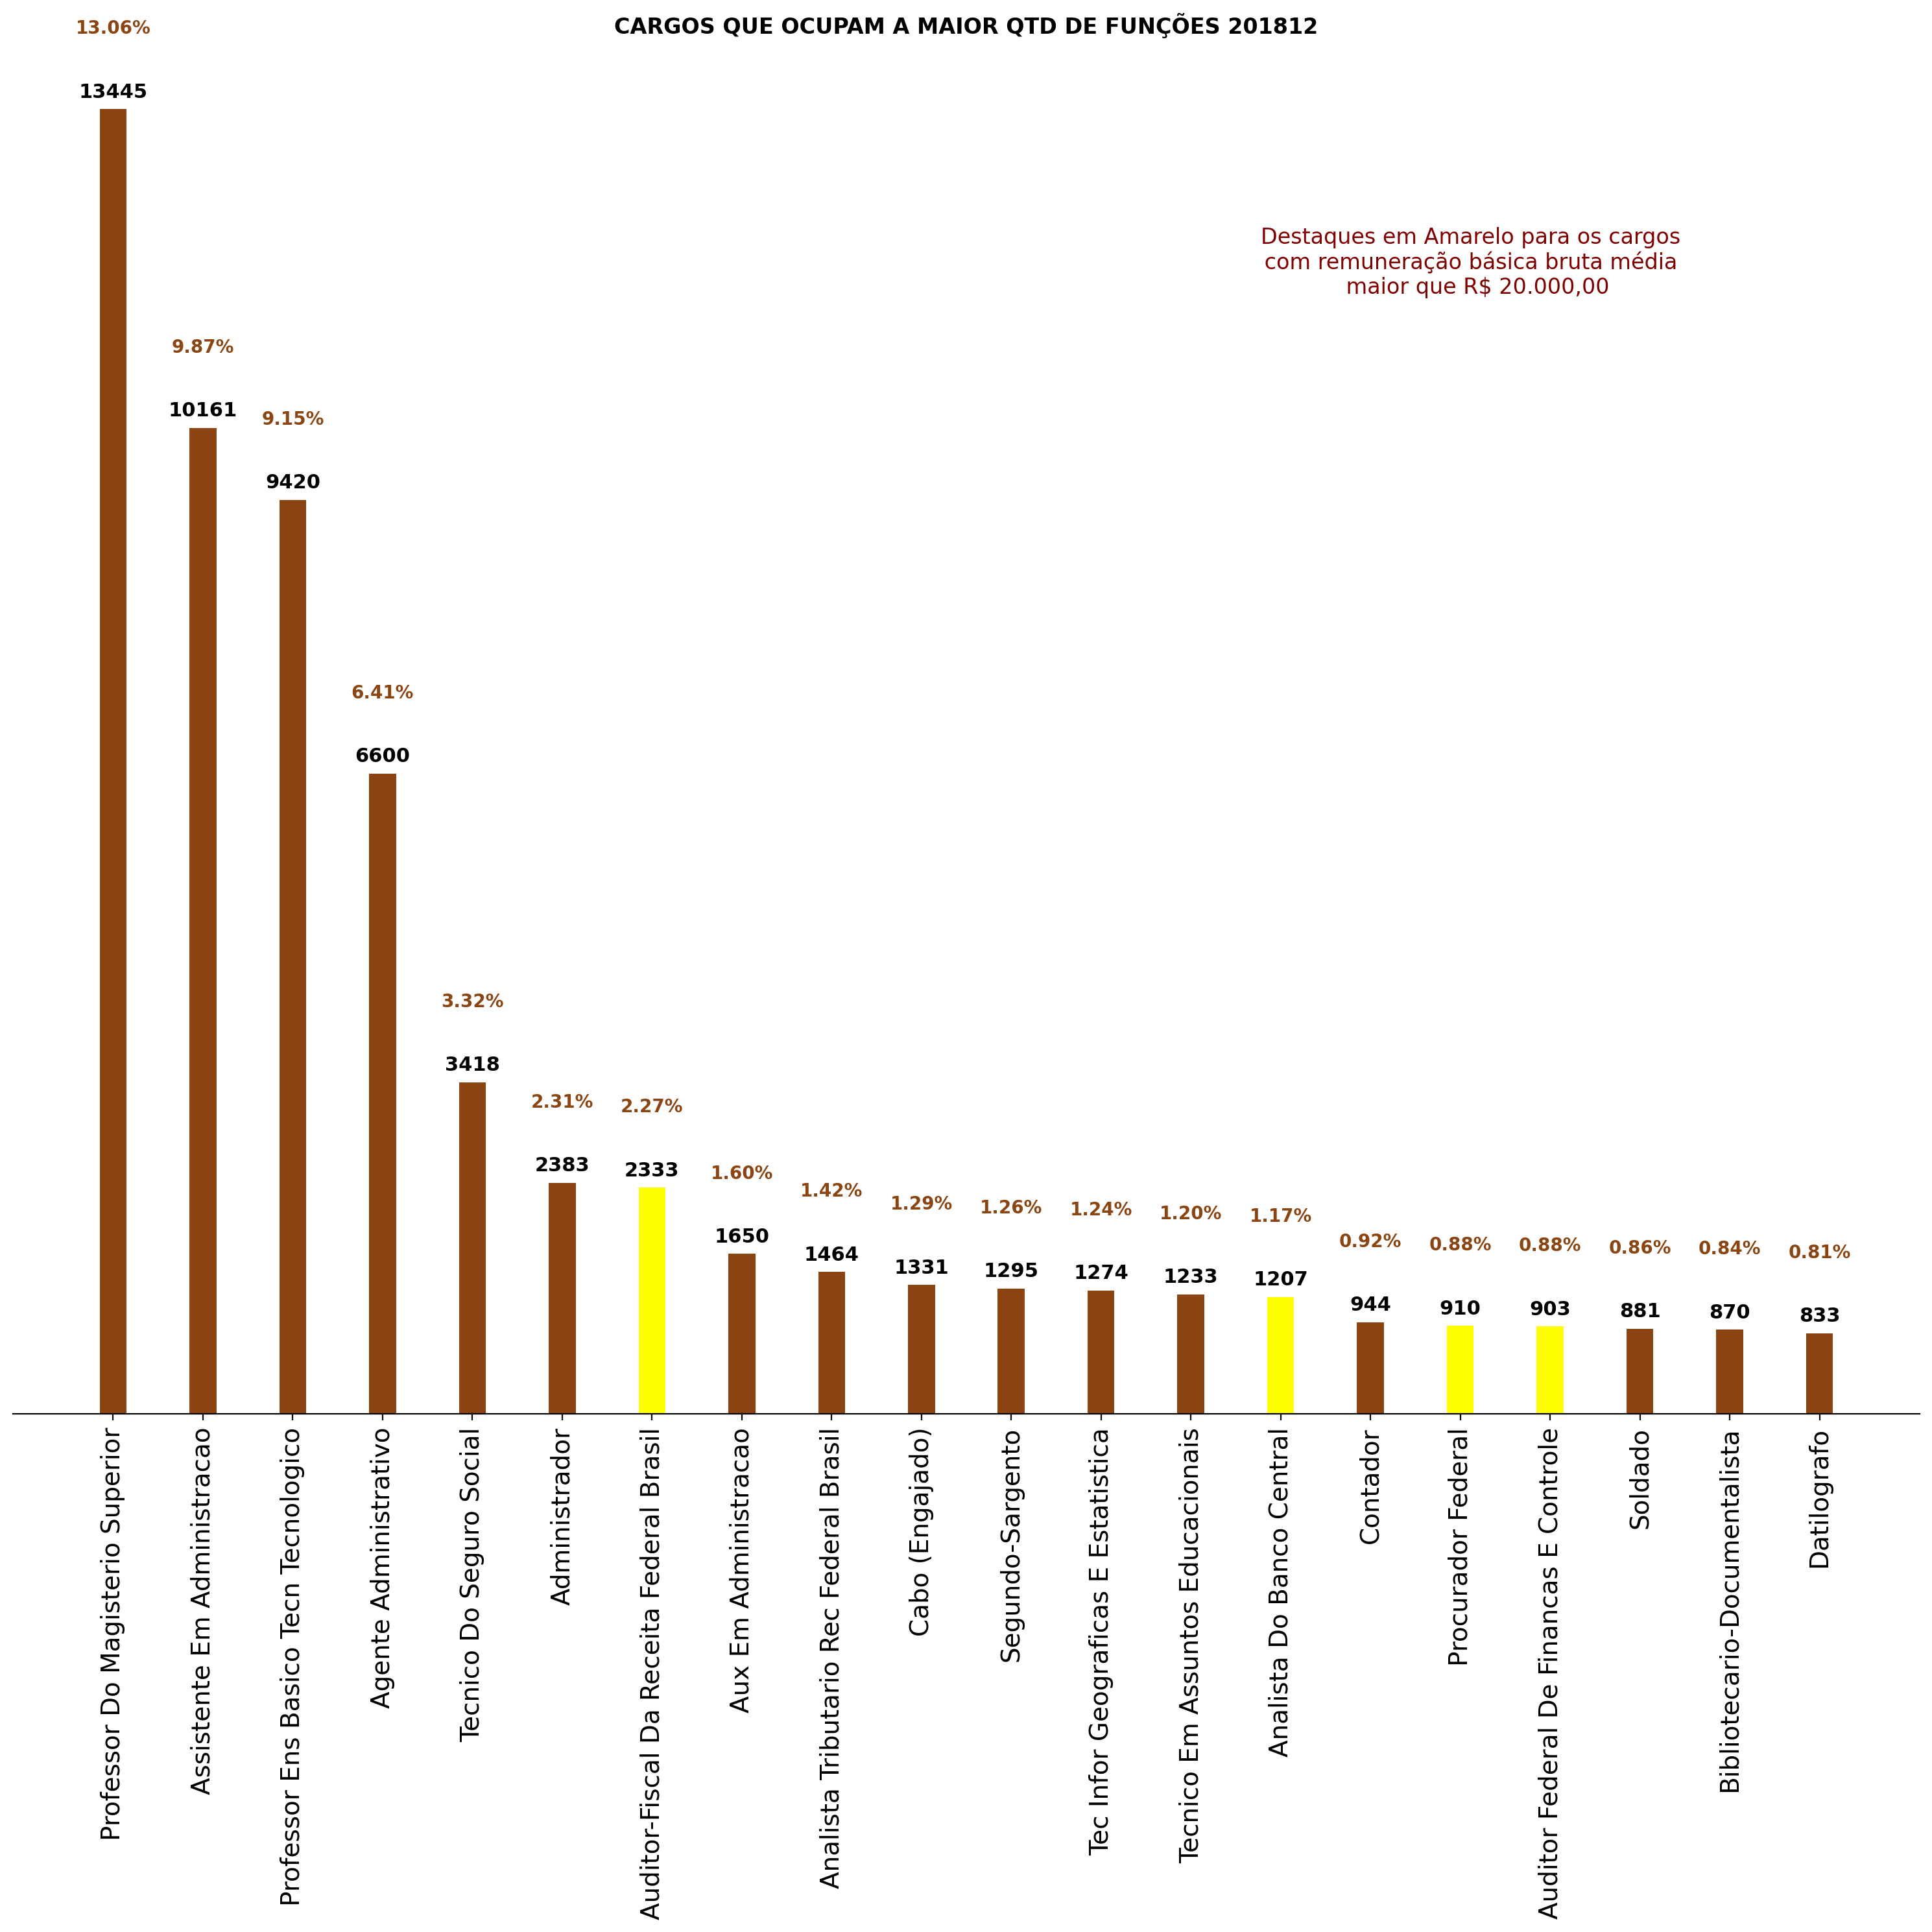

In [1480]:
# Elaboração do gráfico com os 20 órgãos com maior quantidade de funções


# plotando gráfico
fig, ax = plt.subplots(dpi=200,figsize=(15,15))

for i in funcoes_list_graf.index:
    if funcoes_list_graf["MÉDIA REMUNERAÇÃO"][i] >= 20000:
        ax.bar(funcoes_list_graf["DESCRICAO_CARGO"][i],funcoes_list_graf["CONT"][i],
           color="#FFFF00", # Cor das barras
           width = 0.3, 
                    )
    else:
        ax.bar(funcoes_list_graf["DESCRICAO_CARGO"][i],funcoes_list_graf["CONT"][i],
           color="#8B4513", # Cor das barras
           width = 0.3,
         
          )

ax.set_title("CARGOS QUE OCUPAM A MAIOR QTD DE FUNÇÕES {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#000000') # Cor da fonte

for i in np.arange(0, len(list(funcoes_list_graf["DESCRICAO_CARGO"]))):
    ax.annotate(funcoes_list_graf["CONT"][i], # texto do annotate
                  (funcoes_list_graf["DESCRICAO_CARGO"][i], funcoes_list_graf["CONT"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(0,15), 
                    textcoords = "offset points", 
                    fontsize=11,
                    color = '#000000',
                    fontweight='bold')

for i in np.arange(0, len(list(funcoes_list_graf["DESCRICAO_CARGO"]))):
    ax.annotate("{:,.2f}%".format(funcoes_list_graf["PORCENTAGEM"][i]*100), # texto do annotate
                  (funcoes_list_graf["DESCRICAO_CARGO"][i], funcoes_list_graf["CONT"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(0,50), 
                    textcoords = "offset points", 
                    fontsize=10,
                    color = '#8B4513',
                    fontweight='bold')


    

ax.set_yticks([0,8000])  
ax.tick_params(axis='x',labelsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.set_visible(False) # retira os valores de Y
ax.tick_params(axis='x',labelsize=14) # ajusta o tamanho dos valores de Y
plt.xticks(rotation=90)
    
ax1 = fig.add_axes([0.7145,0.1,0.093,0.74]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.00)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Destaques em Amarelo para os cargos \n com remuneração básica bruta média  \n maior que R$ 20.000,00", color="#800000")
    


plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\H-Quantidade de Funções por Cargo {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\H-Quantidade de Funções por Cargo (Exercicio) {}.pdf".format(referencia, referencia), transparent = True)
#plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

#### Tabela com as Respectivas Funções para cada Cargo

In [1481]:
func = pd.merge(func, cargo_todos, on= "DESCRICAO_CARGO", how= "left")

func["SIGLA_FUNCAO_y"] = func["SIGLA_FUNCAO_y"].astype("str")
func["NIVEL_FUNCAO_y"] = func["NIVEL_FUNCAO_y"].astype("str")

func["FUNCAO"] = func["SIGLA_FUNCAO_y"] + " " + func["NIVEL_FUNCAO_y"]

func = func.groupby([ "DESCRICAO_CARGO","MÉDIA REMUNERAÇÃO","FUNCAO"])["CONT"].sum()

func.to_excel("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Tabelas\H-Quantidade de Funções por Cargo {}.xlsx".format(referencia, referencia))

#####  PESSOAL POR CARGO (Gráfico Top 20 Maiores Remunerações)

In [1482]:
# Criação de variável para considerar somente as 20 maiores remunerações, considando a ordem da Remuneração Média

cargos_todos_grafico = cargo_todos.head(20)

In [1483]:
fig, ax = plt.subplots(dpi=200,nrows=3,ncols=1,figsize=(15,15),gridspec_kw={'height_ratios': [1.2, 1.2,2]})

#__________________________________________________PORCENTAGEM DO TOTAL DE PESSOAS__________________________________________

ax[0].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"],
       color="#FF4500", # Cor das barras
       width = 0.3)

ax[0].set_title("PORCENTAGEM DO TOTAL DE PESSOAL NO CARGO (EM RELAÇÃO AO TOTAL DE PESSOAL) {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte
    
for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] >= 0.006:    
        ax[0].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,-25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
        
    elif (cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] < 0.006) & (cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] > 0.0001):
        ax[0].annotate("{:,.3f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
    else: 
        ax[0].annotate("{:,.4f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)

ax[0].set_yticks([0,0.01]) 
ax[0].tick_params(axis='x',labelsize=14)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].yaxis.set_visible(False) # retira os valores de Y
ax[0].xaxis.set_visible(False) # retira os valores de x



#__________________________________________________PORCENTAGEM DO TOTAL DO CUSTO DO CARGO__________________________________

ax[1].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"],
       color="#FFA500", # Cor das barras
       width = 0.3)

ax[1].set_title("PORCENTAGEM DO TOTAL CUSTO DO CARGO (EM RELAÇÃO AO TOTAL DO CUSTO DE TODOS OS CARGOS) \n (PARÂMETRO: REMUNERAÇÃO BASICA BRUTA) {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte
    
for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] >= 0.02:    
        ax[1].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,-25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
        
    elif (cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] < 0.02) & (cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] > 0.0001):
        ax[1].annotate("{:,.3f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
    else: 
        ax[1].annotate("{:,.4f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)

ax[1].set_yticks([0,0.01]) 
ax[1].tick_params(axis='x',labelsize=14)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].yaxis.set_visible(False) # retira os valores de Y
ax[1].xaxis.set_visible(False) # retira os valores de x


#__________________________________________________MÉDIA REMUNERAÇÃO______________________________________________________

ax[2].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["MÉDIA REMUNERAÇÃO"],
       color="#FFFF00", # Cor das barras
       width = 0.3)
ax[2].plot(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["MÉDIA REMUNERAÇÃO"],
       color="#FF4500") # Cor da linha

ax[2].set_title("TOP 20 MAIORES REMUNERAÇÕES (MÉDIA POR CARGO) \n (PARÂMETRO: REMUNERAÇÃO BASICA BRUTA)  {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte

for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    ax[2].annotate("R$ {:,.0f}".format(cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]).replace(",", "."), # texto do annotate
                  (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(2,-15), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#363636',
                    fontweight='bold',
                    rotation=90)


ax[2].set_yticks([0,40000])  
ax[2].tick_params(axis='x',labelsize=14)
ax[2].spines["top"].set_visible(False)
ax[2].spines["right"].set_visible(False)
ax[2].spines["left"].set_visible(False)
ax[2].yaxis.set_visible(False) # retira os valores de Y
ax[2].tick_params(axis='x',labelsize=14) # ajusta o tamanho dos valores de Y

plt.xticks(rotation=90)
plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço

plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\I-Quantitativo Por Cargo e Remuneração (TOP 20 Remuneração) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\I-Quantitativo Por Cargo e Remuneração (TOP 20 Remuneração) {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

#####  PESSOAL POR CARGO (Gráfico Top 20 Maior Quantidade de Pessoal)

In [1484]:
cargo_todos = cargo_todos.sort_values(by = "TOTAL PESSOAS CARGO", ascending=False)

In [1485]:
# Criação de variável para considerar somente os 20 cargos com maior número de pessoal

cargos_todos_grafico = cargo_todos.head(20)
cargos_todos_grafico = cargos_todos_grafico.reset_index()

In [1486]:
fig, ax = plt.subplots(dpi=200,nrows=3,ncols=1,figsize=(15,15),gridspec_kw={'height_ratios': [1.2, 1.2,2]})

#__________________________________________________PORCENTAGEM DO TOTAL DE PESSOAS__________________________________________

ax[0].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"],
       color="#FF4500", # Cor das barras
       width = 0.3)
ax[0].plot(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"],
       color="#FF4500") # Cor da linha

ax[0].set_title("TOP 20 - PORCENTAGEM DO TOTAL DE PESSOAL NO CARGO (EM RELAÇÃO AO TOTAL DE PESSOAL) {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte
    
for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] >= 0.07:    
        ax[0].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,-5), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#363636',
                        fontweight='bold',
                        rotation=90)
        
    elif (cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] < 0.07) & (cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] > 0.01):
        ax[0].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
    else: 
        ax[0].annotate("{:,.4f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)

ax[0].set_yticks([0,0.01]) 
ax[0].tick_params(axis='x',labelsize=14)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].yaxis.set_visible(False) # retira os valores de Y
ax[0].xaxis.set_visible(False) # retira os valores de x



#__________________________________________________PORCENTAGEM DO TOTAL DO CUSTO DO CARGO__________________________________

ax[1].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"],
       color="#FFA500", # Cor das barras
       width = 0.3)

ax[1].set_title("PORCENTAGEM DO TOTAL CUSTO DO CARGO (EM RELAÇÃO AO TOTAL DO CUSTO DE TODOS OS CARGOS) \n (PARÂMETRO: REMUNERAÇÃO BASICA BRUTA) {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte
    
for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] >= 0.09:    
        ax[1].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,-25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
        
    elif (cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] < 0.09) & (cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] > 0.001):
        ax[1].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
    else: 
        ax[1].annotate("{:,.4f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)

ax[1].set_yticks([0,0.01]) 
ax[1].tick_params(axis='x',labelsize=14)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].yaxis.set_visible(False) # retira os valores de Y
ax[1].xaxis.set_visible(False) # retira os valores de x


#__________________________________________________MÉDIA REMUNERAÇÃO______________________________________________________

ax[2].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["MÉDIA REMUNERAÇÃO"],
       color="#FFFF00", # Cor das barras
       width = 0.3)


ax[2].set_title("REMUNERAÇÕES (MÉDIA POR CARGO) \n (PARÂMETRO: REMUNERAÇÃO BASICA BRUTA)  {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte

for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    ax[2].annotate("R$ {:,.0f}".format(cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]).replace(",", "."), # texto do annotate
                  (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(2,80), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#363636',
                    fontweight='bold',
                    rotation=90)


ax[2].set_yticks([0,40000])  
ax[2].tick_params(axis='x',labelsize=14)
ax[2].spines["top"].set_visible(False)
ax[2].spines["right"].set_visible(False)
ax[2].spines["left"].set_visible(False)
ax[2].yaxis.set_visible(False) # retira os valores de Y
ax[2].tick_params(axis='x',labelsize=14) # ajusta o tamanho dos valores de Y

plt.xticks(rotation=90)
plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço

plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\I-Quantitativo Por Cargo e Remuneração (TOP 20 Pessoal) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\I-Quantitativo Por Cargo e Remuneração (TOP 20 Pessoal) {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

#####  PESSOAL POR CARGO (Gráfico Top 20 Maiores Custos)

In [1487]:
cargo_todos = cargo_todos.sort_values(by = "CUSTO DO CARGO", ascending=False)

In [1488]:
# Criação de variável para considerar somente os 20 cargos com maior custo

cargos_todos_grafico = cargo_todos.head(20)
cargos_todos_grafico = cargos_todos_grafico.reset_index()

In [1489]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,15),gridspec_kw={'height_ratios': [1.2, 1.2,2]})

#__________________________________________________PORCENTAGEM DO TOTAL DE PESSOAS__________________________________________

ax[0].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"],
       color="#FF4500", # Cor das barras
       width = 0.3)


ax[0].set_title("PORCENTAGEM DO TOTAL DE PESSOAL NO CARGO (EM RELAÇÃO AO TOTAL DE PESSOAL) {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte
    
for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] >= 0.07:    
        ax[0].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,-5), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#363636',
                        fontweight='bold',
                        rotation=90)
        
    elif (cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] < 0.07) & (cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i] > 0.01):
        ax[0].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
    else: 
        ax[0].annotate("{:,.4f}%".format(cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM DO TOTAL DE PESSOAS"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)

ax[0].set_yticks([0,0.01]) 
ax[0].tick_params(axis='x',labelsize=14)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].yaxis.set_visible(False) # retira os valores de Y
ax[0].xaxis.set_visible(False) # retira os valores de x



#__________________________________________________PORCENTAGEM DO TOTAL DO CUSTO DO CARGO__________________________________

ax[1].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"],
       color="#FFA500", # Cor das barras
       width = 0.3)
ax[1].plot(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"],
       color="#FF4500") # Cor da linha

ax[1].set_title("TOP 20 - CUSTO DO CARGO (EM RELAÇÃO AO TOTAL DO CUSTO DE TODOS OS CARGOS) \n (PARÂMETRO: REMUNERAÇÃO BASICA BRUTA) {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte
    
for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] >= 0.09:    
        ax[1].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,-25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
        
    elif (cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] < 0.09) & (cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i] > 0.001):
        ax[1].annotate("{:,.2f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(2,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)
    else: 
        ax[1].annotate("{:,.4f}%".format(cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]*100), # texto do annotate
                      (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["PORCENTAGEM CUSTO CARGO"][i]), #posição x, y
                        ha="center", 
                        va = "top",
                        xytext=(0,60), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000',
                        fontweight='bold',
                        rotation=90)

ax[1].set_yticks([0,0.01]) 
ax[1].tick_params(axis='x',labelsize=14)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].yaxis.set_visible(False) # retira os valores de Y
ax[1].xaxis.set_visible(False) # retira os valores de x


#__________________________________________________MÉDIA REMUNERAÇÃO______________________________________________________

ax[2].bar(cargos_todos_grafico["DESCRICAO_CARGO"],cargos_todos_grafico["MÉDIA REMUNERAÇÃO"],
       color="#FFFF00", # Cor das barras
       width = 0.3)


ax[2].set_title("REMUNERAÇÕES (MÉDIA POR CARGO) \n (PARÂMETRO: REMUNERAÇÃO BASICA BRUTA)  {}".format(referencia), # Título do gráfico
             fontsize=12, # Tamanho da fonte
             fontweight='bold', # Espessura da fonte
             color='#363636') # Cor da fonte

for i in np.arange(0, len(list(cargos_todos_grafico["DESCRICAO_CARGO"]))):
    if cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i] > 25000:
        ax[2].annotate("R$ {:,.0f}".format(cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]).replace(",", "."), # texto do annotate
                  (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(2,-10), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#363636',
                    fontweight='bold',
                    rotation=90)    
    else:
        ax[2].annotate("R$ {:,.0f}".format(cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]).replace(",", "."), # texto do annotate
                  (cargos_todos_grafico["DESCRICAO_CARGO"][i], cargos_todos_grafico["MÉDIA REMUNERAÇÃO"][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(2,80), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#363636',
                    fontweight='bold',
                    rotation=90)


ax[2].set_yticks([0,40000])  
ax[2].tick_params(axis='x',labelsize=14)
ax[2].spines["top"].set_visible(False)
ax[2].spines["right"].set_visible(False)
ax[2].spines["left"].set_visible(False)
ax[2].yaxis.set_visible(False) # retira os valores de Y
ax[2].tick_params(axis='x',labelsize=14) # ajusta o tamanho dos valores de Y

plt.xticks(rotation=90)
plt.tight_layout() # para enquadrar melhor a imagem e não cortar nenhum pedaço

plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\I-Quantitativo Por Cargo e Remuneração (TOP 20 Custo Órgão) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\I-Quantitativo Por Cargo e Remuneração (TOP 20 Custo Órgão) {}.pdf".format(referencia, referencia), transparent = True)
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
#plt.show()

### Gráfico de Dispersão com o Cruzamento da média remuneração com o quantitativo de pessoal

In [1490]:
faixas = cargo_todos.reset_index()

In [1491]:
faixa1 = faixas.loc[faixas["MÉDIA REMUNERAÇÃO"] <= 5000]
faixa1 = faixa1["TOTAL PESSOAS CARGO"].sum()
faixa1_porcent = faixa1/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa2 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 5000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 10000)]
faixa2 = faixa2["TOTAL PESSOAS CARGO"].sum()
faixa2_porcent = faixa2/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa3 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 10000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 15000)]
faixa3 = faixa3["TOTAL PESSOAS CARGO"].sum()
faixa3_porcent = faixa3/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa4 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 15000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 20000)]
faixa4 = faixa4["TOTAL PESSOAS CARGO"].sum()
faixa4_porcent = faixa4/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa5 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 20000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 25000)]
faixa5 = faixa5["TOTAL PESSOAS CARGO"].sum()
faixa5_porcent = faixa5/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa6 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 25000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 30000)]
faixa6 = faixa6["TOTAL PESSOAS CARGO"].sum()
faixa6_porcent = faixa6/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa7 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 30000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 35000)]
faixa7 = faixa7["TOTAL PESSOAS CARGO"].sum()
faixa7_porcent = faixa7/faixas["TOTAL PESSOAS CARGO"].sum()*100

faixa8 = faixas.loc[faixas["MÉDIA REMUNERAÇÃO"] > 35000]
faixa8 = faixa8["TOTAL PESSOAS CARGO"].sum()
faixa8_porcent = faixa8/faixas["TOTAL PESSOAS CARGO"].sum()*100

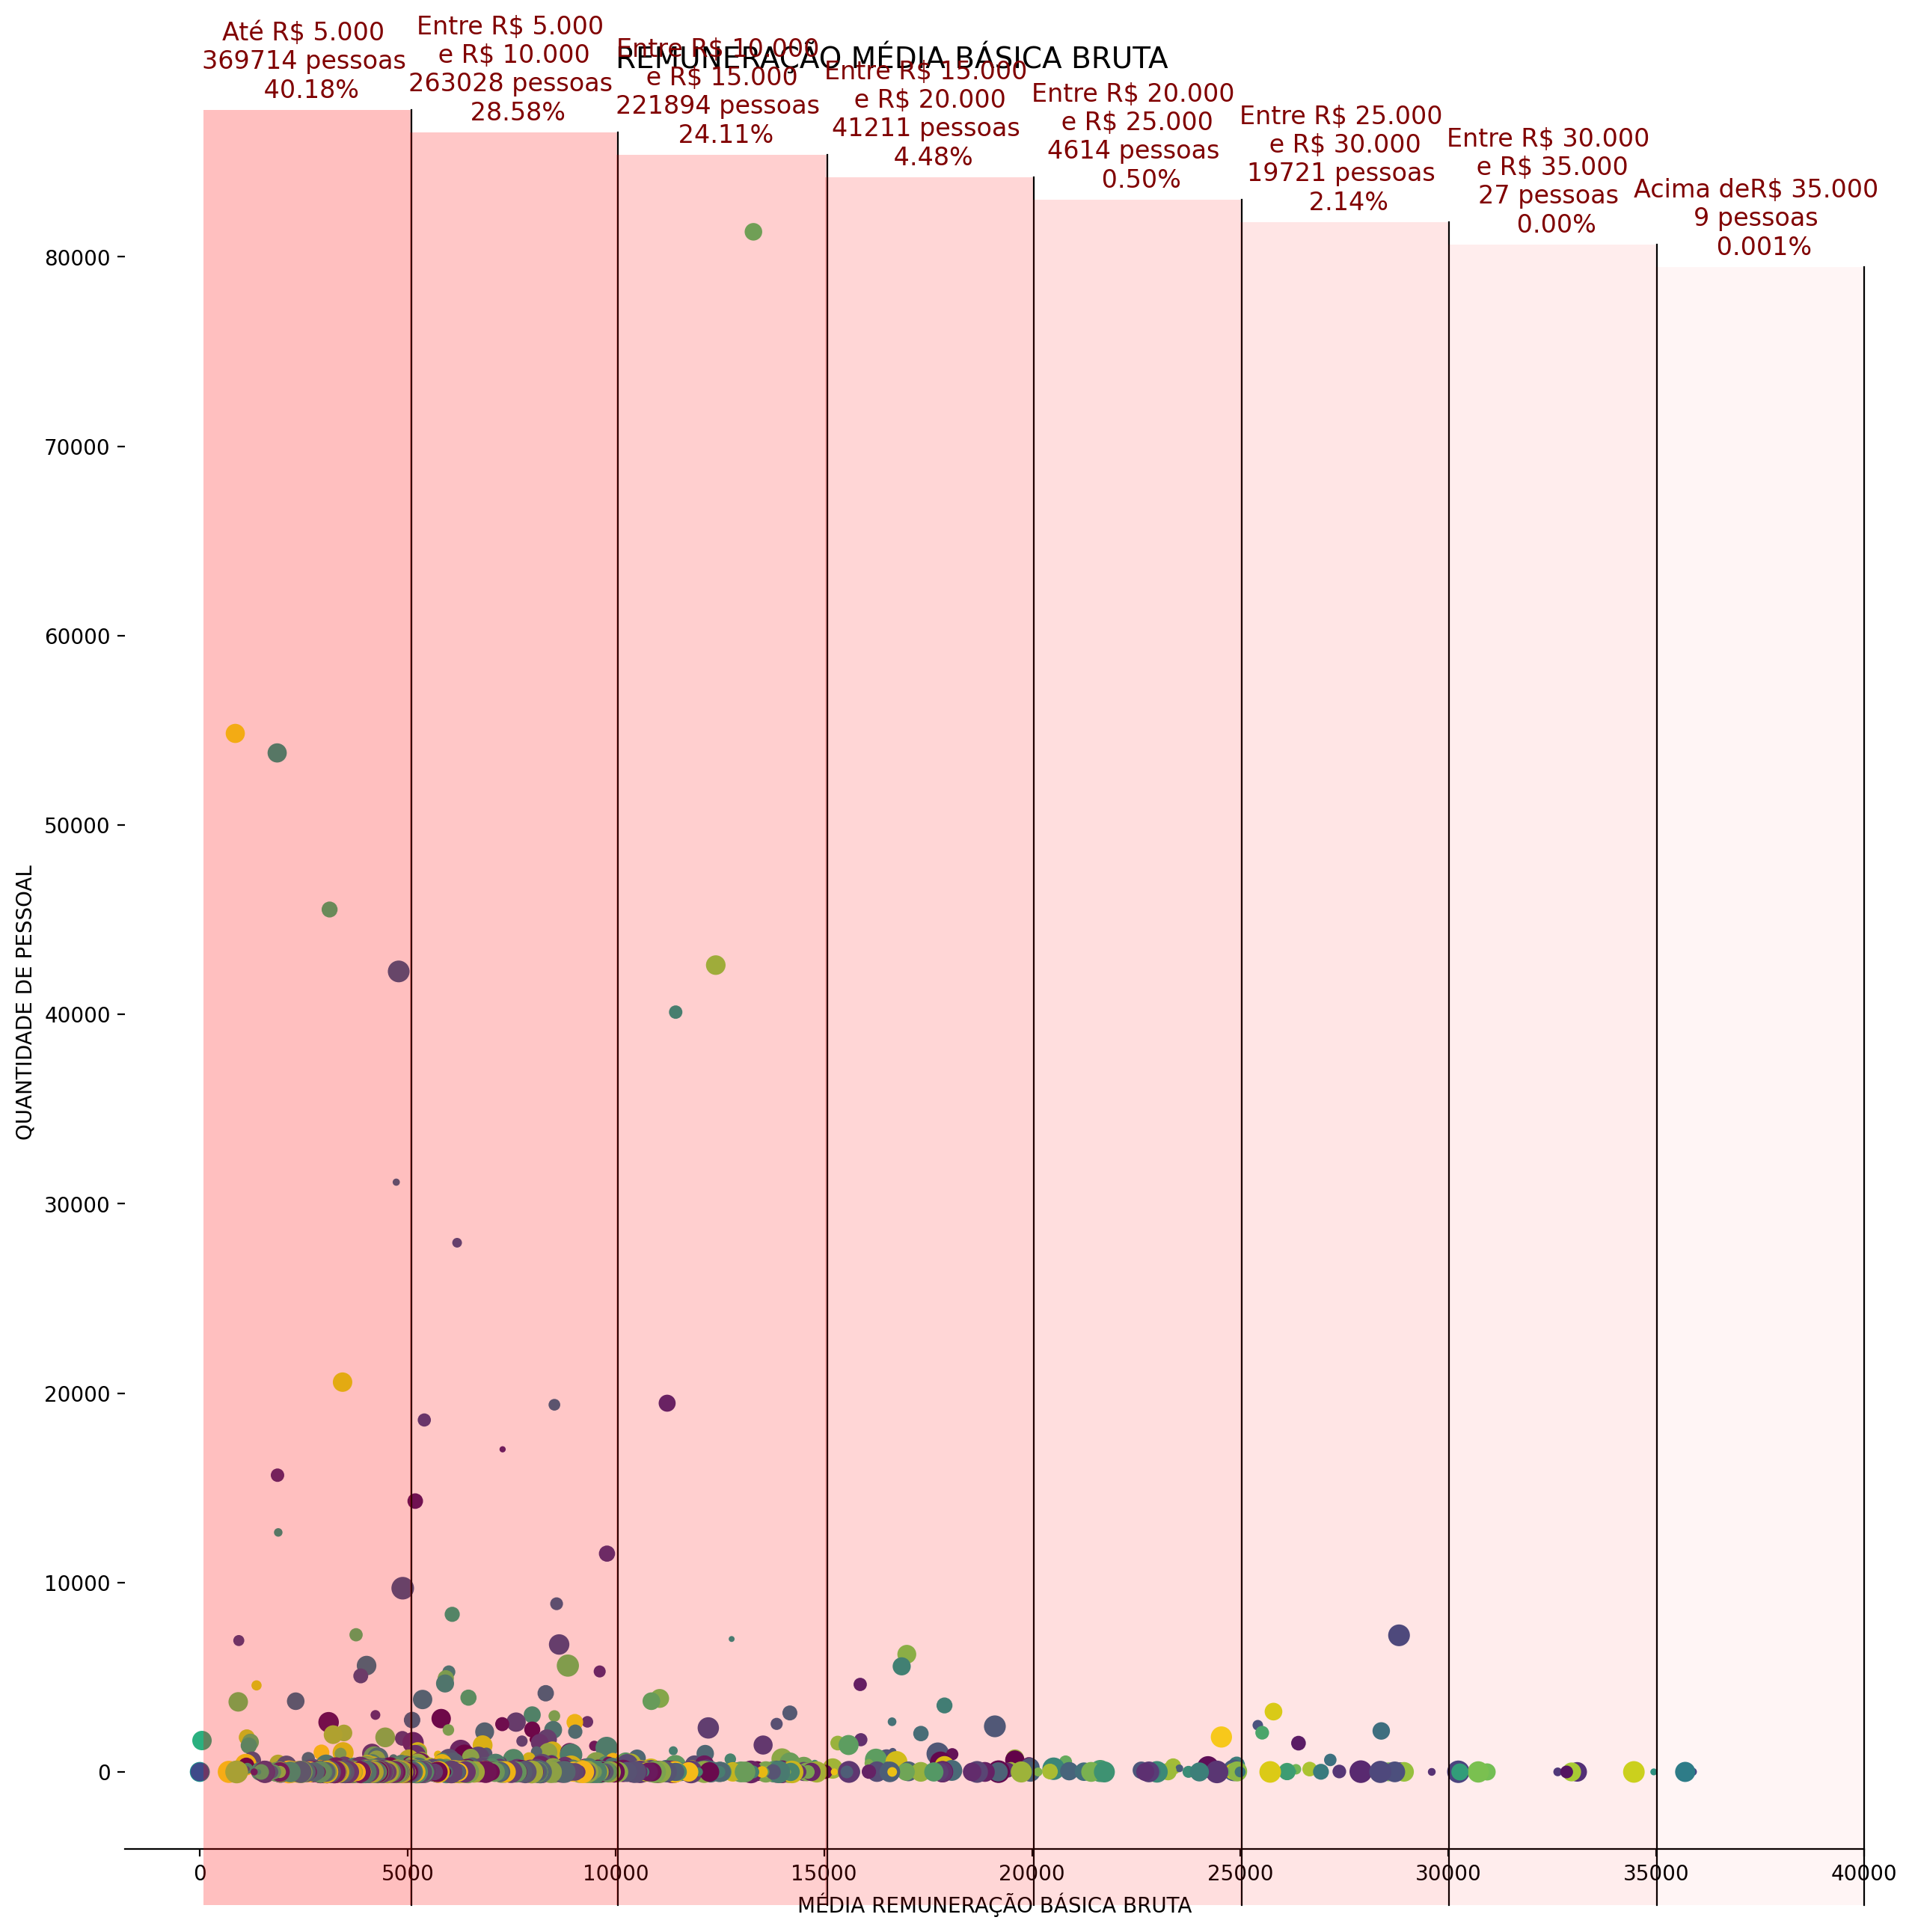

In [1492]:
# Gráfico de Dispersão da remuneração pela quantidade de pessoas

# plot
fig, ax = plt.subplots(dpi=200, figsize=(15,15))


np.random.seed(3)
x = cargo_todos["MÉDIA REMUNERAÇÃO"]
y = cargo_todos["TOTAL PESSOAS CARGO"]
# size and color:
sizes = np.random.uniform(1, 100, len(y))
colors = np.random.uniform(1, 100, len(x))
plt.text(10000, 90000, 
         "REMUNERAÇÃO MÉDIA BÁSICA BRUTA", 
         fontsize=14, color= "#000000")


ax.scatter(x, y, s=sizes, c=colors, vmin=0, vmax=100)
ax.set_yticks(np.arange(0, 90000, 10000)) 
ax.set_xticks(np.arange(0, 45000, 5000))
ax.set_xlabel("MÉDIA REMUNERAÇÃO BÁSICA BRUTA")
ax.set_ylabel("QUANTIDADE DE PESSOAL")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)



ax1 = fig.add_axes([0.16,0.1,0.0927,0.8]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.25)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Até R$ 5.000 \n{} pessoas \n {:,.2f}%".format(faixa1, faixa1_porcent), color="#800000")

ax1 = fig.add_axes([0.252,0.1,0.0927,0.79]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.22)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Entre R$ 5.000 \n e R$ 10.000 \n{} pessoas \n {:,.2f}%".format(faixa2,faixa2_porcent), color= "#800000")

ax1 = fig.add_axes([0.344,0.1,0.094,0.78]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.19)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Entre R$ 10.000 \n e R$ 15.000 \n{} pessoas \n {:,.2f}%".format(faixa3,faixa3_porcent), color="#800000")


ax1 = fig.add_axes([0.437,0.1,0.093,0.77]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.16)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Entre R$ 15.000 \n e R$ 20.000 \n{} pessoas \n {:,.2f}%".format(faixa4,faixa4_porcent), color="#800000")


ax1 = fig.add_axes([0.5295,0.1,0.093,0.76]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.13)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Entre R$ 20.000 \n e R$ 25.000 \n{} pessoas \n {:,.2f}%".format(faixa5,faixa5_porcent), color="#800000")

ax1 = fig.add_axes([0.622,0.1,0.093,0.75]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.10)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Entre R$ 25.000 \n e R$ 30.000 \n{} pessoas \n {:,.2f}%".format(faixa6,faixa6_porcent), color="#800000")

ax1 = fig.add_axes([0.7145,0.1,0.093,0.74]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.07)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Entre R$ 30.000 \n e R$ 35.000 \n{} pessoas \n {:,.2f}%".format(faixa7,faixa7_porcent), color="#800000")

ax1 = fig.add_axes([0.807,0.1,0.093,0.73]) # <- [esquerda,fundo,largura,altura] em fração da figura
rect = ax1.patch
rect.set_facecolor('#FF0000')
rect.set_alpha(0.04)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title("Acima deR$ 35.000 \n{} pessoas \n {:,.3f}%".format(faixa8,faixa8_porcent), color="#800000")


plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\I-Quantitativo Por Cargo e Remuneração (DISPERSÃO) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\I-Quantitativo Por Cargo e Remuneração (DISPERSÃO) {}.pdf".format(referencia, referencia), transparent = True)
#plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória

In [1493]:
# obtendo a remuneração básica bruta para fazer o gráfico de dispersão 
func_dispersao = pd.merge(func_dispersao, cargo_todos, on= "DESCRICAO_CARGO", how= "left")
faixas = func_dispersao

In [1494]:
faixa1 = faixas.loc[faixas["MÉDIA REMUNERAÇÃO"] <= 5000]
faixa1 = faixa1["CONT"].sum()
faixa1_porcent = faixa1/faixas["CONT"].sum()*100

faixa2 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 5000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 10000)]
faixa2 = faixa2["CONT"].sum()
faixa2_porcent = faixa2/faixas["CONT"].sum()*100

faixa3 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 10000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 15000)]
faixa3 = faixa3["CONT"].sum()
faixa3_porcent = faixa3/faixas["CONT"].sum()*100

faixa4 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 15000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 20000)]
faixa4 = faixa4["CONT"].sum()
faixa4_porcent = faixa4/faixas["CONT"].sum()*100

faixa5 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 20000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 25000)]
faixa5 = faixa5["CONT"].sum()
faixa5_porcent = faixa5/faixas["CONT"].sum()*100

faixa6 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 25000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 30000)]
faixa6 = faixa6["CONT"].sum()
faixa6_porcent = faixa6/faixas["CONT"].sum()*100

faixa7 = faixas.loc[(faixas["MÉDIA REMUNERAÇÃO"] > 30000) & (faixas["MÉDIA REMUNERAÇÃO"] <= 35000)]
faixa7 = faixa7["CONT"].sum()
faixa7_porcent = faixa7/faixas["CONT"].sum()*100

faixa8 = faixas.loc[faixas["MÉDIA REMUNERAÇÃO"] > 35000]
faixa8 = faixa8["CONT"].sum()
faixa8_porcent = faixa8/faixas["CONT"].sum()*100

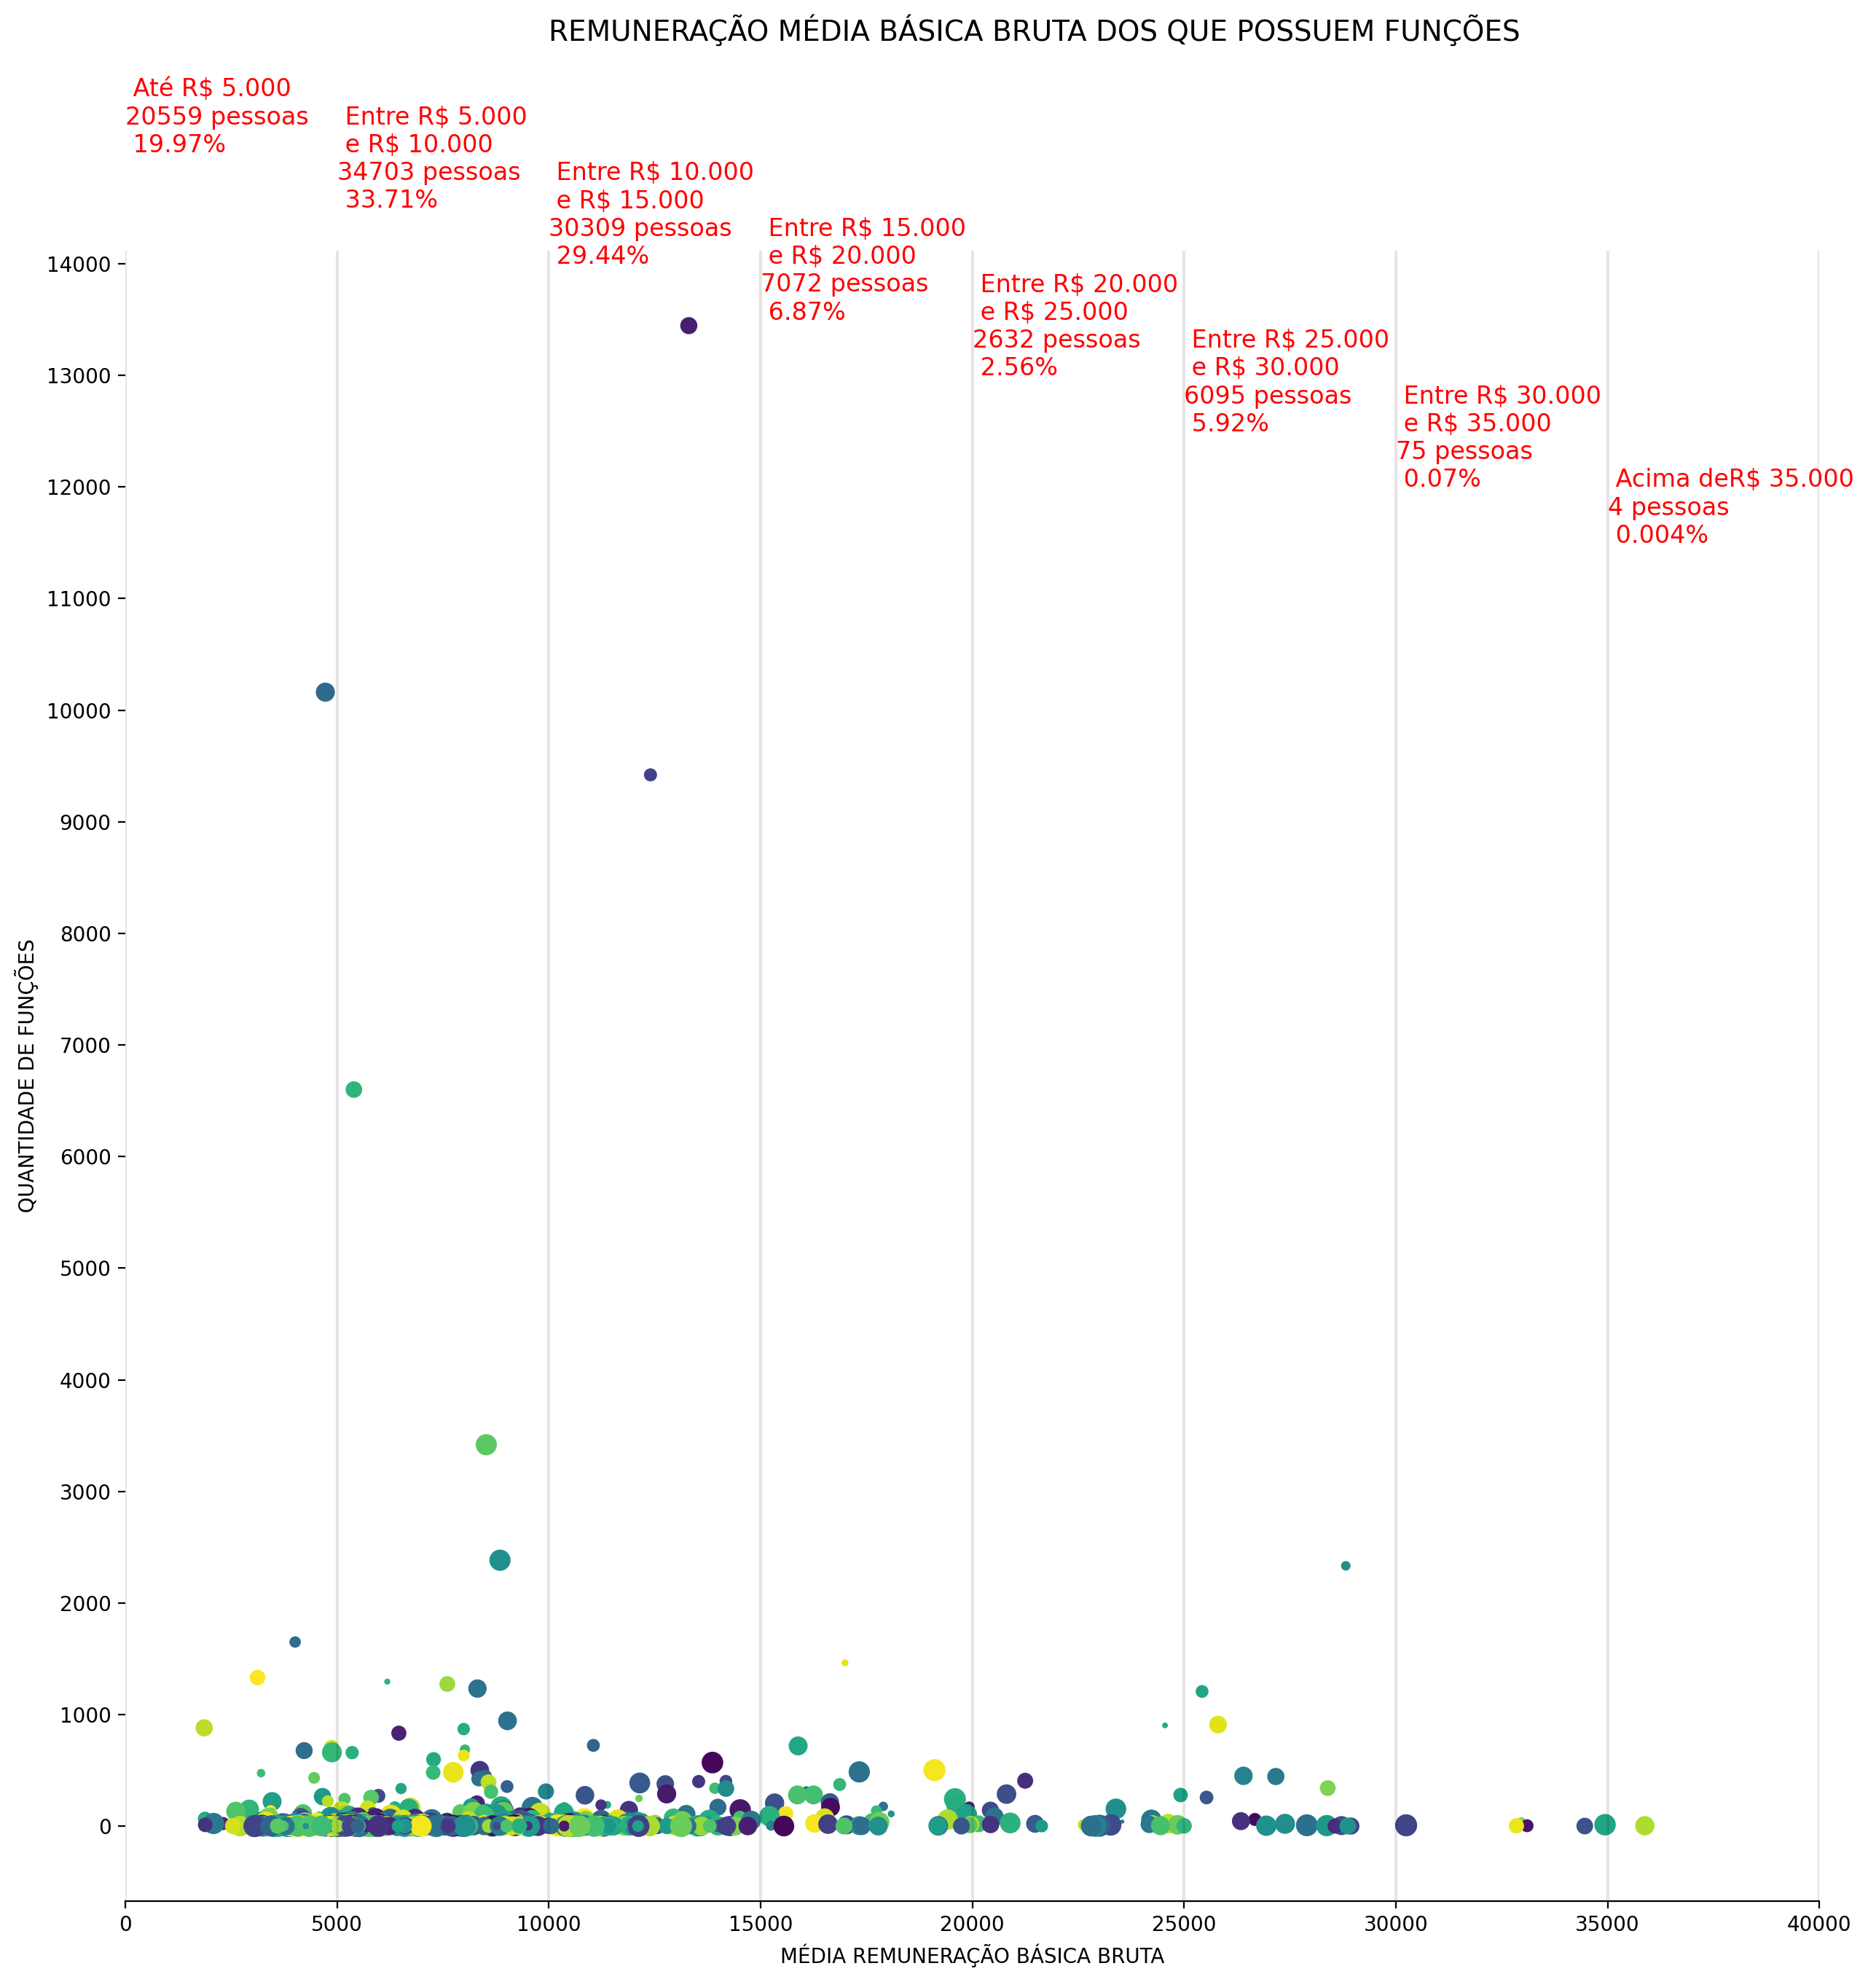

In [1495]:
# Gráfico de Dispersão da remuneração pela quantidade de funções

# plot
fig, ax = plt.subplots(dpi=200, figsize=(15,15))


np.random.seed(3)
x = func_dispersao["MÉDIA REMUNERAÇÃO"]
y = func_dispersao["CONT"]
# size and color:
sizes = np.random.uniform(1, 100, len(y))
colors = np.random.uniform(1, 100, len(x))


ax.scatter(x, y, s=sizes, c=colors, vmin=0, vmax=100)
ax.set_yticks(np.arange(0, 15000, 1000)) 
ax.set_xticks(np.arange(0, 45000, 5000))
ax.set_xlabel("MÉDIA REMUNERAÇÃO BÁSICA BRUTA")
ax.set_ylabel("QUANTIDADE DE FUNÇÕES")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.axvline(x=0, ymin=0, ymax=16000, color='#000000', alpha= 0.1)
plt.axvline(x=5000, ymin=0, ymax=16000, color='#000000', alpha= 0.1)
plt.axvline(x=10000, ymin=0, ymax=15500, color='#000000', alpha= 0.1)
plt.axvline(x=15000, ymin=0, ymax=15000, color='#000000', alpha= 0.1)
plt.axvline(x=20000, ymin=0, ymax=14500, color='#000000', alpha= 0.1)
plt.axvline(x=25000, ymin=0, ymax=14000, color='#000000', alpha= 0.1)
plt.axvline(x=30000, ymin=0, ymax=13400, color='#000000', alpha= 0.1)
plt.axvline(x=35000, ymin=0, ymax=13000, color='#000000', alpha= 0.1)
plt.axvline(x=40000, ymin=0, ymax=1250, color='#000000', alpha= 0.1)

plt.text(10000, 16000, 
         "REMUNERAÇÃO MÉDIA BÁSICA BRUTA DOS QUE POSSUEM FUNÇÕES", 
         fontsize=14, color= "#000000")
plt.text(0, 15000, 
         " Até R$ 5.000 \n{} pessoas \n {:,.2f}%".format(faixa1, faixa1_porcent), 
         fontsize=12, color= "#FF0000")
plt.text(5000, 14500, 
         " Entre R$ 5.000 \n e R$ 10.000 \n{} pessoas \n {:,.2f}%".format(faixa2,faixa2_porcent), 
         fontsize=12, color= "#FF0000")

plt.text(10000, 14000, 
         " Entre R$ 10.000 \n e R$ 15.000 \n{} pessoas \n {:,.2f}%".format(faixa3,faixa3_porcent), 
         fontsize=12, color= "#FF0000")

plt.text(15000, 13500, 
         " Entre R$ 15.000 \n e R$ 20.000 \n{} pessoas \n {:,.2f}%".format(faixa4,faixa4_porcent), 
         fontsize=12, color= "#FF0000")

plt.text(20000, 13000, 
         " Entre R$ 20.000 \n e R$ 25.000 \n{} pessoas \n {:,.2f}%".format(faixa5,faixa5_porcent), 
         fontsize=12, color= "#FF0000")

plt.text(25000, 12500, 
         " Entre R$ 25.000 \n e R$ 30.000 \n{} pessoas \n {:,.2f}%".format(faixa6,faixa6_porcent), 
         fontsize=12, color= "#FF0000")

plt.text(30000, 12000, 
         " Entre R$ 30.000 \n e R$ 35.000 \n{} pessoas \n {:,.2f}%".format(faixa7,faixa7_porcent), 
         fontsize=12, color= "#FF0000")

plt.text(35000, 11500, 
         " Acima deR$ 35.000 \n{} pessoas \n {:,.3f}%".format(faixa8,faixa8_porcent), 
         fontsize=12, color= "#FF0000")


plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em JPG\H-Quantitativo Por Função e Remuneração (DISPERSÃO) {}.jpg".format(referencia, referencia), transparent = True)
plt.savefig("PORTAL DA TRANSPARENCIA\{} RESULTADOS\Graficos em PDF\H-Quantitativo Por Função e Remuneração (DISPERSÃO) {}.pdf".format(referencia, referencia), transparent = True)
#plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória

In [1496]:
# exclusão de Diretórios Desnecessários: 
try:    
    shutil.rmtree("PORTAL DA TRANSPARENCIA/{} EXTRAÇÕES".format(referencia))
    
except:
    pass

# Relatórios Anuais 

- Os arquivos são "Puxados" do Diretório Temp

## Evolução Civil x Militar  - AA

In [1497]:
# Trazendo todas as  respectivas planilhas

caminho_bases = pathlib.Path('PORTAL DA TRANSPARENCIA/TEMP/Civil x Militar')

base = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    df = pd.read_excel(caminho_bases / arquivo.name, sheet_name = "Sheet1")

    base = pd.concat([base, df])

In [1498]:
# transformação de linhas em colunas (Militar em uma coluna e Civil em outra) Referencia e quantidade em linhas

base_civmil = base.pivot("REFERENCIA", "CIVIL x MILITAR", "PORCENTAGEM")

# resetando o index

base_civmil = base_civmil.reset_index()

# substituindo valores nulos por zero 

base_civmil.fillna(0, inplace=True)

In [1499]:
if "Militar" in base_civmil.columns:

    fig, ax = plt.subplots(dpi=100, figsize=(15,4))

    ax.set_title("Civil x Militar (%)", fontweight='bold')


    ax.plot(base_civmil["REFERENCIA"],base_civmil["Civil"],
           color="#FF0000", # Cor da linha
           linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           linewidth= 2, # espessura da linha
           label= "Civil" )   # legenda

    for i in range(0, len(list(base_civmil["REFERENCIA"]))):
        ax.annotate("{:,.2f}%".format(base_civmil["Civil"][i]*100), # texto do annotate
                      (base_civmil["REFERENCIA"][i],base_civmil["Civil"][i]), #posição x, y
                        ha="center", 
                        xytext=(0,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')   

    ax.plot(base_civmil["REFERENCIA"],base_civmil["Militar"],
           color="#000000", # Cor da linha
           linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           linewidth= 2, # espessura da linha
           label= "Militar" )   # legenda
    for i in range(0, len(list(base_civmil["REFERENCIA"]))):
        ax.annotate("{:,.2f}%".format(base_civmil["Militar"][i]*100), # texto do annotate
                      (base_civmil["REFERENCIA"][i],base_civmil["Militar"][i]), #posição x, y
                        ha="center", 
                        xytext=(0,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')   


    ax.xaxis.set_ticks(base_civmil["REFERENCIA"]) 
    ax.set_yticks([0,1]) 
    ax.tick_params(axis='x',labelsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
    ax.set_ylabel("INFLAÇÃO")
    ax.yaxis.set_visible(False) # retira os valores de Y
    #ax.xaxis.set_visible(False) # retira os valores de x
    ax.legend();
    plt.savefig(r"PORTAL DA TRANSPARENCIA\GRÁFICOS HISTÓRICOS\Evolução Civil x Militar (porcentagem).jpg")
    plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
    

else: 
    pass


## Evolução Civil x Militar  - AA (Nº Absolutos)

In [1500]:
# transformação de linhas em colunas (Militar em uma coluna e Civil em outra) Referencia e quantidade em linhas

base_civmil_absol = base.pivot("REFERENCIA", "CIVIL x MILITAR", "CONT")

# resetando o index

base_civmil_absol = base_civmil_absol.reset_index()

# substituindo valores nulos por zero 

base_civmil_absol.fillna(0, inplace=True)


# Se não houver militar na tabela, não haverá soma
if "Militar" in base_civmil.columns:
    base_civmil_absol["Total"] = base_civmil_absol["Civil"] + base_civmil_absol["Militar"]
else:
    pass

In [1501]:
if "Militar" in base_civmil.columns:

    fig, ax = plt.subplots(dpi=100, figsize=(15,8))

    ax.set_title("Evolução Geral (Civil e Militar)", fontweight='bold')

#________________________________________________________________Total____________________________________________________
    
    ax.plot(base_civmil_absol["REFERENCIA"],base_civmil_absol["Total"],
           color="#0000FF", # Cor da linha
           linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           linewidth= 2, # espessura da linha
           label= "Total" )   # legenda

    for i in range(0, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.0f}".format(base_civmil_absol["Total"][i]).replace(",", "."), # texto do annotate
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Total"][i]), #posição x, y
                        ha="center", 
                        xytext=(0,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')   
    soma = 0
    for i in range(1, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.2f}%".format((base_civmil_absol["Total"][i] - base_civmil_absol["Total"].iloc[i-1])/base_civmil_absol["Total"][i-1]*100), 
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Total"][i]), #posição x, y
                        ha="center", 
                        xytext=(15,25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#0000FF')   
        soma = soma + (base_civmil_absol["Total"][i] - base_civmil_absol["Total"].iloc[i-1])/base_civmil_absol["Total"][i-1]*100
#___________________________________________________________Civil__________________________________________________________
    
    ax.plot(base_civmil_absol["REFERENCIA"],base_civmil_absol["Civil"],
           color="#FF0000", # Cor da linha
           linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           linewidth= 2, # espessura da linha
           label= "Civil" )   # legenda

    for i in range(0, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.0f}".format(base_civmil_absol["Civil"][i]).replace(",", "."), # texto do annotate
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Civil"][i]), #posição x, y
                        ha="center", 
                        xytext=(0,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')
    soma1 = 0
    for i in range(1, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.2f}%".format((base_civmil_absol["Civil"][i] - base_civmil_absol["Civil"].iloc[i-1])/base_civmil_absol["Civil"][i-1]*100), 
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Civil"][i]), #posição x, y
                        ha="center", 
                        xytext=(15,25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#FF0000')   
        soma1 = soma1 + (base_civmil_absol["Civil"][i] - base_civmil_absol["Civil"].iloc[i-1])/base_civmil_absol["Civil"][i-1]*100
#_____________________________________________________________Militar__________________________________________________________

    ax.plot(base_civmil_absol["REFERENCIA"],base_civmil_absol["Militar"],
           color="#000000", # Cor da linha
           linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           linewidth= 2, # espessura da linha
           label= "Militar" )   # legenda
    for i in range(0, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.0f}".format(base_civmil_absol["Militar"][i]).replace(",", "."), # texto do annotate
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Militar"][i]), #posição x, y
                        ha="center", 
                        xytext=(0,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')
    soma2 = 0
    for i in range(1, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.2f}%".format((base_civmil_absol["Militar"][i] - base_civmil_absol["Militar"].iloc[i-1])/base_civmil_absol["Militar"][i-1]*100), 
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Militar"][i]), #posição x, y
                        ha="center", 
                        xytext=(15,25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')
        soma2 = soma2 + (base_civmil_absol["Militar"][i] - base_civmil_absol["Militar"].iloc[i-1])/base_civmil_absol["Militar"][i-1]*100


    ax.xaxis.set_ticks(base_civmil["REFERENCIA"]) 
    ax.set_yticks([0,1500000]) 
    ax.tick_params(axis='x',labelsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
    ax.set_ylabel("INFLAÇÃO")
    ax.yaxis.set_visible(False) # retira os valores de Y
    #ax.xaxis.set_visible(False) # retira os valores de x
    ax.legend(loc="upper left");

# _________________________________________________________Soma Percentuais___________________________________________________

    #______________________________________TOTAL____
    
    ax1 = fig.add_axes([0.9,0.2,0.093,0.4]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    if soma > 0:
        ax1.set_title(" Crescimento \n no período: \n {:,.2f}%".format(soma), color="#0000FF")
    else:
        ax1.set_title(" Decréscimo \n no período: \n {:,.2f}%".format(soma), color="#0000FF")
    
    #______________________________________CIVIL____
    
    ax1 = fig.add_axes([0.9,0.2,0.093,0.24]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    if soma1 > 0:
        ax1.set_title(" Crescimento \n no período: \n {:,.2f}%".format(soma1), color="#FF0000")
    else:
        ax1.set_title(" Decréscimo \n no período: \n {:,.2f}%".format(soma1), color="#FF0000")
    
    #______________________________________MILITAR____

    ax1 = fig.add_axes([0.9,0.2,0.093,0.05]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    if soma2 > 0:
        ax1.set_title(" Crescimento \n no período: \n {:,.2f}%".format(soma2), color="#000000")
    else:
        ax1.set_title(" Decréscimo \n no período: \n {:,.2f}%".format(soma2), color="#000000")
    
    plt.savefig(r"PORTAL DA TRANSPARENCIA\GRÁFICOS HISTÓRICOS\Evolução Geral - Civil e Militar (número absoluto).jpg")
    plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
    
else: 

    fig, ax = plt.subplots(dpi=100, figsize=(10,5))

    ax.set_title("Evolução Geral (Civil)", fontweight='bold')


#___________________________________________________________Civil__________________________________________________________
    
    ax.plot(base_civmil_absol["REFERENCIA"],base_civmil_absol["Civil"],
           color="#FF0000", # Cor da linha
           linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           linewidth= 2, # espessura da linha
           label= "Civil" )   # legenda

    for i in range(0, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.0f}".format(base_civmil_absol["Civil"][i]).replace(",", "."), # texto do annotate
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Civil"][i]), #posição x, y
                        ha="center", 
                        xytext=(0,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')
    soma1 = 0
    for i in range(1, len(list(base_civmil_absol["REFERENCIA"]))):
        ax.annotate("{:,.2f}%".format((base_civmil_absol["Civil"][i] - base_civmil_absol["Civil"].iloc[i-1])/base_civmil_absol["Civil"][i-1]*100), 
                      (base_civmil_absol["REFERENCIA"][i],base_civmil_absol["Civil"][i]), #posição x, y
                        ha="center", 
                        xytext=(15,25), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#FF0000')   
        soma1 = soma1 + (base_civmil_absol["Civil"][i] - base_civmil_absol["Civil"].iloc[i-1])/base_civmil_absol["Civil"][i-1]*100

 
    ax.xaxis.set_ticks(base_civmil["REFERENCIA"]) 
    ax.set_yticks([0,1000000]) 
    ax.tick_params(axis='x',labelsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
    ax.set_ylabel("INFLAÇÃO")
    ax.yaxis.set_visible(False) # retira os valores de Y
    #ax.xaxis.set_visible(False) # retira os valores de x
    ax.legend(loc="upper left");
    
    #______________________________________CIVIL____
    
    ax1 = fig.add_axes([0.9,0.2,0.093,0.24]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    if soma1 > 0:
        ax1.set_title(" Crescimento \n no período: \n {:,.2f}%".format(soma1), color="#FF0000")
    else:
        ax1.set_title(" Decréscimo \n no período: \n {:,.2f}%".format(soma1), color="#FF0000")
    
    
    
    plt.savefig(r"PORTAL DA TRANSPARENCIA\GRÁFICOS HISTÓRICOS\Evolução Geral - Civil (número absoluto).jpg")
    plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória


## Evolução Vínculo Funcional  - C

In [1502]:
# Trazendo todas as  respectivas planilhas

caminho_bases = pathlib.Path('PORTAL DA TRANSPARENCIA/TEMP/Quantitativo por Vínculo Funcional')

base = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    df = pd.read_excel(caminho_bases / arquivo.name, sheet_name = "Sheet1")

    base = pd.concat([base, df])

# Fazendo a União daqueles vínculos que possuem abaixo de 15000 registros

base.loc[base["PORCENTAGEM"] <0.012, "SITUACAO_VINCULO"] = "Outros" 
base = base.groupby(["REFERENCIA", "SITUACAO_VINCULO"])["PORCENTAGEM"].sum()
base = base.reset_index()

In [1503]:
# transformação de linhas em colunas (Situação Vínculo em colunas) Referencia e quantidade em linhas

base_vinc = base.pivot("REFERENCIA", "SITUACAO_VINCULO", "PORCENTAGEM")

# resetando o index

base_vinc = base_vinc.reset_index()

# substituindo valores nulos por zero 

base_vinc.fillna(0, inplace=True)

In [1504]:
fig, ax = plt.subplots(dpi=100, figsize=(15,8))
#______________________________________________________________________________________________________________________    
    
ax.set_title("Evolução Vínculo Funcional", fontweight='bold')
                 
for coluna in base_vinc.columns[1:]:     
    ax.plot(base_vinc["REFERENCIA"],base_vinc[coluna],
           #color="#FF0000", # Cor da linha
           #linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           #linewidth= 2, # espessura da linha
           label= coluna )   # legenda
    for i in range(0, len(list(base_vinc["REFERENCIA"]))):
        if coluna == "Ativo Permanente" or coluna == "Militar Da Ativa":
            ax.annotate("{:,.2f}%".format(base_vinc[coluna][i]*100), # texto do annotate
                      (base_vinc["REFERENCIA"][i],base_vinc[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(2,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')   
        else:
            if coluna == "Outros":
                ax.annotate("{:,.2f}%".format(base_vinc[coluna][i]*100), # texto do annotate
                      (base_vinc["REFERENCIA"][i],base_vinc[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,19), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000')
            elif coluna == "Celetista/Empregado":
                ax.annotate("{:,.2f}%".format(base_vinc[coluna][i]*100), # texto do annotate
                      (base_vinc["REFERENCIA"][i],base_vinc[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,-6), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000')
            elif coluna == "Sem Vinculo":
                ax.annotate("{:,.2f}%".format(base_vinc[coluna][i]*100), # texto do annotate
                      (base_vinc["REFERENCIA"][i],base_vinc[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,-3), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000') 
            elif coluna == "Contrato Temporario":
                ax.annotate("{:,.2f}%".format(base_vinc[coluna][i]*100), # texto do annotate
                      (base_vinc["REFERENCIA"][i],base_vinc[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,-3), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000')

ax.xaxis.set_ticks(base_vinc["REFERENCIA"]) 
ax.set_yticks([-0.1,0.1]) 
ax.tick_params(axis='x',labelsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
ax.yaxis.set_visible(False) # retira os valores de Y
#ax.xaxis.set_visible(False) # retira os valores de x
ax.legend();
plt.savefig(r"PORTAL DA TRANSPARENCIA\GRÁFICOS HISTÓRICOS\Evolução Vínculo Funcional.jpg")
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória

## Evolução Regime Jurídico  - D

In [1505]:
# Trazendo todas as  respectivas planilhas

caminho_bases = pathlib.Path('PORTAL DA TRANSPARENCIA/TEMP/Quantitativo por Regime Jurídico')

base = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    df = pd.read_excel(caminho_bases / arquivo.name, sheet_name = "Sheet1")

    base = pd.concat([base, df])

# Fazendo a União daqueles vínculos que possuem abaixo de 300 registros

base.loc[base["PORCENTAGEM"] <0.02, "REGIME_JURIDICO"] = "Outros" 
base = base.groupby(["REFERENCIA", "REGIME_JURIDICO"])["PORCENTAGEM"].sum()
base = base.reset_index()

In [1506]:
# transformação de linhas em colunas (Situação Vínculo em colunas) Referencia e quantidade em linhas

base_reg = base.pivot("REFERENCIA", "REGIME_JURIDICO", "PORCENTAGEM")

# resetando o index

base_reg = base_reg.reset_index()

# substituindo valores nulos por zero 

base_reg.fillna(0, inplace=True)

In [1507]:
fig, ax = plt.subplots(dpi=100, figsize=(15,8))
#______________________________________________________________________________________________________________________    
    
ax.set_title("Evolução Regime Jurídico", fontweight='bold')
                 
for coluna in base_reg.columns[1:]:     
    ax.plot(base_reg["REFERENCIA"],base_reg[coluna],
           #color="#FF0000", # Cor da linha
           #linestyle="dashdot", #estilo da linha
           marker="o", # marcação dos pontos
           #linewidth= 2, # espessura da linha
           label= coluna )   # legenda
    for i in range(0, len(list(base_reg["REFERENCIA"]))):
        if coluna == "Regime Juridico Unico" or coluna == "Estatuto Dos Militares":
            ax.annotate("{:,.2f}%".format(base_reg[coluna][i]*100), # texto do annotate
                      (base_reg["REFERENCIA"][i],base_reg[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(2,9), 
                        textcoords = "offset points", 
                        fontsize=11,
                        color = '#000000')   
        else:
            if coluna == "Outros":
                ax.annotate("{:,.2f}%".format(base_reg[coluna][i]*100), # texto do annotate
                      (base_reg["REFERENCIA"][i],base_reg[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,4), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000')
            elif coluna == "Consolidacao Das Leis Do Trabalho":
                ax.annotate("{:,.2f}%".format(base_reg[coluna][i]*100), # texto do annotate
                      (base_reg["REFERENCIA"][i],base_reg[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,10), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000')

            elif coluna == "Contrato Temporario":
                ax.annotate("{:,.2f}%".format(base_reg[coluna][i]*100), # texto do annotate
                      (base_reg["REFERENCIA"][i],base_reg[coluna][i]), #posição x, y
                        ha="center", 
                        xytext=(16,-7), 
                        textcoords = "offset points", 
                        fontsize=7,
                        color = '#000000')

ax.xaxis.set_ticks(base_reg["REFERENCIA"]) 
ax.set_yticks([0,0.1]) 
ax.tick_params(axis='x',labelsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
ax.yaxis.set_visible(False) # retira os valores de Y
#ax.xaxis.set_visible(False) # retira os valores de x
ax.legend();
plt.savefig(r"PORTAL DA TRANSPARENCIA\GRÁFICOS HISTÓRICOS\Evolução Regime Jurídico.jpg")
plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória

## Histórico Remuneração de cada Cargo - H 

In [1508]:
# Trazendo todas as planilhas refenrentes aos cargos 

caminho_bases = pathlib.Path('PORTAL DA TRANSPARENCIA/TEMP/Quantitativo Por Cargo e Remuneração')

base = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    df = pd.read_excel(caminho_bases / arquivo.name, sheet_name = "Sheet1")

    base = pd.concat([base, df])

In [1509]:
# excluindo linhas que não possui nenhuma pessoa

base = base.drop(base.loc[base["TOTAL PESSOAS CARGO"] == 0].index)

In [1510]:
# renomeando as futuras colunas para que as barras não se confundam com o enderço da pasta

base["DESCRICAO_CARGO"] = base["DESCRICAO_CARGO"].str.replace("/", " ")  

In [1511]:
# transformação de linhas em colunas (cada cargo em uma coluna) - REMUNERAÇÃO

base_remun = base.pivot("REFERENCIA", "DESCRICAO_CARGO", "MÉDIA REMUNERAÇÃO")

# resetando o index

base_remun = base_remun.reset_index()

# substituindo valores nulos por zero 

base_remun.fillna(0, inplace=True)

In [1512]:
# transformação de linhas em colunas (cada cargo em uma coluna) - PESSOAS NO CARGO

base_pessoal = base.pivot("REFERENCIA", "DESCRICAO_CARGO", "TOTAL PESSOAS CARGO")

# resetando o index

base_pessoal = base_pessoal.reset_index()

# substituindo valores nulos por zero 

base_pessoal.fillna(0, inplace=True)

In [1513]:
#  inflação informada manualmente, buscar métodos de automatizaçao

inflacao = pd.DataFrame({"ANO": np.arange(2013, 2023),
                        "INFLAÇÃO":[5.91, 6.41, 10.67, 6.29, 2.95, 3.75, 4.31, 4.52, 10.06, 11.73]})

pbar = tqdm(total=len(base_remun.columns), position=0, leave=True)
for coluna in base_remun.columns[1:]:
    pbar.update()
    fig, ax = plt.subplots(dpi=100, nrows=3,ncols=1, figsize=(15,10),gridspec_kw={'height_ratios': [1,2,1]})
#______________________________________________________________________________________________________________________    
    
    ax[0].set_title("{}".format(coluna), fontweight='bold')
                 
    
    ax[0].plot(inflacao["ANO"],inflacao["INFLAÇÃO"],
       color="#FF0000", # Cor da linha
       linestyle="dotted", #estilo da linha
       marker="o", # marcação dos pontos
       linewidth= 2, # espessura da linha
       label= "Inflação" )   # legenda
    for i in range(1, len(list(inflacao["ANO"]))):
        ax[0].annotate("{:,.2f}%".format(inflacao["INFLAÇÃO"][i]), # texto do annotate
                  (inflacao["ANO"][i],inflacao["INFLAÇÃO"][i]), #posição x, y
                    ha="center", 
                    xytext=(0,9), 
                    textcoords = "offset points", 
                    fontsize=11,
                    color = '#000000',
                  )   
    
    ax[0].set_yticks([0,15]) 
    ax[0].tick_params(axis='x',labelsize=14)
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["left"].set_visible(False)
    ax[0].spines["bottom"].set_visible(False)
    ax[0].set_ylabel("INFLAÇÃO")
    ax[0].yaxis.set_visible(False) # retira os valores de Y
    ax[0].xaxis.set_visible(False) # retira os valores de x
    ax[0].legend(loc="lower left")

 #___________________________________________________________________________________________________________________   
    
    ax[1].bar(base_remun["REFERENCIA"],base_remun[coluna],
           color="#800000", # Cor das barras
           width = 10)
    
    for i in np.arange(0, len(list(base_remun["REFERENCIA"]))):
        ax[1].annotate("R$ {:,.0f}".format(base_remun[coluna][i]).replace(",", "."), # texto do annotate
                  (base_remun["REFERENCIA"][i], base_remun[coluna][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(2,80), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#363636',
                    fontweight='bold',
                    rotation=90) 
    soma= 0
    for i in np.arange(1, len(list(base_remun["REFERENCIA"]))):
        ax[1].annotate("{:,.2f}%".format((base_remun[coluna].iloc[i] - base_remun[coluna].iloc[i-1])/ base_remun[coluna].iloc[i-1]*100), # texto do annotate
                  (base_remun["REFERENCIA"][i], base_remun[coluna][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(35,20), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#800000')
        
        soma = soma +(base_remun[coluna].iloc[i] - base_remun[coluna].iloc[i-1])/ base_remun[coluna].iloc[i-1]*100
  

    
    
    #ax[1].xaxis.set_ticks(base_remun["REFERENCIA"])
    ax[1].set_yticks([0,50000]) 
    #ax[1].yaxis.set_visible(False) # retira os valores de Y
    ax[1].xaxis.set_visible(False) # retira os valores de Y
    ax[1].spines["top"].set_visible(False) # retirr as bordas do gráfico (topo)
    ax[1].spines["right"].set_visible(False) # retirr as bordas do gráfico (direita)
    ax[1].spines["left"].set_visible(False) # retirr as bordas do gráfico (esquerda)
    #ax[1].spines["bottom"].set_visible(False)
    #ax[1].set_xlabel("ANO MÊS REFERÊNCIA")
    ax[1].set_ylabel("MÉDIA REMUNERAÇÃO", fontweight='bold')
    #plt.xticks(rotation=90)
 #_________________________________________________________________________________________________________________ 
    
    ax[2].stackplot(base_pessoal["REFERENCIA"],base_pessoal[coluna],
           color="#800000",
           alpha = 0.2)
    
    for i in np.arange(0, len(list(base_pessoal["REFERENCIA"]))):
        ax[2].annotate("{:,.0f}".format(base_pessoal[coluna][i]).replace(",", "."), # texto do annotate
                  (base_pessoal["REFERENCIA"][i], base_pessoal[coluna][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(-1,30), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#363636',
                    fontweight='bold',
                    rotation=90)
        if base_pessoal[coluna][i] < 500:
            tamanho = 500
        elif base_pessoal[coluna][i] > 500 and base_pessoal[coluna][i] < 1000:
            tamanho = 1000
        elif base_pessoal[coluna][i] > 1000 and base_pessoal[coluna][i] < 5000:
            tamanho = 5000
        elif base_pessoal[coluna][i] > 5000 and base_pessoal[coluna][i] < 10000:
            tamanho = 10000
        elif base_pessoal[coluna][i] > 10000 and base_pessoal[coluna][i] < 20000:
            tamanho = 20000
        elif base_pessoal[coluna][i] > 20000 and base_pessoal[coluna][i] < 30000:
            tamanho = 30000
        elif base_pessoal[coluna][i] > 30000 and base_pessoal[coluna][i] < 50000:
            tamanho = 50000
        else: 
            tamanho = 80000
        
    soma1=0
    for i in np.arange(1, len(list(base_pessoal["REFERENCIA"]))):
        ax[2].annotate("{:,.2f}%".format((base_pessoal[coluna].iloc[i] - base_pessoal[coluna].iloc[i-1])/ base_pessoal[coluna].iloc[i-1]*100), # texto do annotate
                  (base_pessoal["REFERENCIA"][i], base_pessoal[coluna][i]), #posição x, y
                    ha="center", 
                    va = "top",
                    xytext=(37,20), 
                    textcoords = "offset points", 
                    fontsize=13,
                    color = '#800000')
        
        soma1 = soma1 +(base_pessoal[coluna].iloc[i] - base_pessoal[coluna].iloc[i-1])/ base_pessoal[coluna].iloc[i-1]*100
        
  
    ax[2].xaxis.set_ticks(base_pessoal["REFERENCIA"])
    ax[2].set_yticks([0,tamanho])
    #ax[2].yaxis.set_visible(False) # retira os valores de Y
    ax[2].spines["top"].set_visible(False) # retirr as bordas do gráfico (topo)
    ax[2].spines["right"].set_visible(False) # retirr as bordas do gráfico (direita)
    ax[2].spines["left"].set_visible(False) # retirr as bordas do gráfico (esquerda)
    ax[2].set_xlabel("\n ANO MÊS REFERÊNCIA \n NOTA: o ganho no período não signfica reajuste salarial \n A média salarial considera a Remuneração Básica Bruta nos respectivos períodos (incluindo valores de eventuais Funções ou Gratificações) \n Progressões e/ou reajustes são considerados no período" , fontweight='bold')
    ax[2].set_ylabel("\n QUANT. SERVIDORES", fontweight='bold')
    #plt.xticks(rotation=90)
        
#_______________________________________________________________________________________________________________________  

    ax1 = fig.add_axes([0.87,0.4,0.093,0.45]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title("Inflação Acumulada \n no período: \n {:,.2f}%".format(inflacao["INFLAÇÃO"][1:].sum()), color="#800000")
    
    ax1 = fig.add_axes([0.87,0.2,0.093,0.45]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_title(" Ganho \n no período: \n {:,.2f}%".format(soma), color="#800000")
 
    ax1 = fig.add_axes([0.87,0.1,0.093,0.17]) # <- [esquerda,fundo,largura,altura] em fração da figura
    rect = ax1.patch
    rect.set_facecolor('#FF0000')
    rect.set_alpha(0.0)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    if soma1 > 0:
        ax1.set_title("Crescrimento \n no período: \n {:,.2f}%".format(soma1), color="#800000")
    else:
        ax1.set_title("Decréscimo \n no período: \n {:,.2f}%".format(soma1), color="#800000")

    
    
    soma= 0 # para zerar a soma do ganho no perído 
    soma1= 0 # para zerar a soma do ganho no perído 
 #_________________________________________________________________________________________________________________   
    plt.savefig(r"PORTAL DA TRANSPARENCIA\GRÁFICOS HISTÓRICOS\Remuneração Cargos\{}.jpg".format(coluna), format="jpg")
    plt.close(fig)  # fechando os arquivos para não sobrecarregar a memória
    #plt.show()
                

In [1514]:
tempo_final = time.time()
minutos = (tempo_final - tempo_inicial)//60
segundos = (tempo_final - tempo_inicial)%60
print("O Programa levou {} minutos e {:,.0f} segundos para processamento".format(minutos, segundos))

O Programa levou 7.0 minutos e 24 segundos para processamento
